# uCB-seq Non-Imaging Data Processing

___

## Load Packages:

In [1]:
suppressWarnings(suppressMessages({
    library(rbin)
    library(data.table)
    library(scater)
    library(tidyverse)
    library(annotables)
    library(SummarizedExperiment)
    library(RColorBrewer)
    library(SingleCellExperiment)
    library(DescTools)
    library(gplots)
    library(eulerr)
    library(grid)
    library(gridExtra) 
    library(GenomicFeatures)
    library(GenomicRanges)
    library(BSgenome)
    }))

## Temporary Functions

In [2]:
setwd('C:/Users/tyler/Desktop/Downsampled zUMIs/out/TC012Final/')
tc012a <- readRDS('TC012A.dgecounts.rds')
tc012b <- readRDS('TC012B.dgecounts.rds')

setwd('C:/Users/tyler/Desktop/Downsampled zUMIs/out/TC014Final/')
tc014a <- readRDS('TC014A.dgecounts.rds')
tc014b <- readRDS('TC014B.dgecounts.rds')

setwd('C:/Users/tyler/Desktop/Downsampled zUMIs/out/TC010Final/')
tc010a <- readRDS('TC010A.dgecounts.rds')

## Preanalysis Processing

In [3]:
# Remove duplicate genes in dedup_grch38.
toRemove <- vector()
last <- 1
for (i in 2:(nrow(grch38))) {
    if (grch38[i,1] == grch38[i - 1,1]) {
        toRemove[last] <- i
        last <- last + 1
    }
}

# Create deuplicated grch38
dedup_grch38 <- grch38[-toRemove,]

# Check for duplicates in dedup_grch38
postDupCount <- 0
for (i in 1:(nrow(dedup_grch38) - 1)) {
    if (dedup_grch38[i,1] == dedup_grch38[i + 1,1]) {
        postDupCount <- postDupCount + 1
    }
}
print(paste0("There are ", postDupCount, " duplicate genes in dedup_grch38!"))

[1] "There are 0 duplicate genes in dedup_grch38!"


___

# Set Parameters for Analysis

In [4]:
# Initialize samples, barcodes, and sampleslist
experiment <- 'All Comparisons'
samples <- c('TC010A', 'TC010B', 'TC012A', 'TC012B', 'TC011C', 'TC011D', 'TC014A', 'TC014B')
barcodes <- c('TCACAGCA', 'GTAGCACT', 'ATAGCGTC', 'CTAGCTGA','CTACGACA', 'GTACGCAT', 'ACATGCGT', 'GCATGTAC', 'ATACGTGC', 'GCAGTATC')
barcodes12 <- c('TCCAGCA', 'GTGCACT', 'ATGCGTC', 'CTGCTGA','CTCGACA', 'GTCGCAT', 'ACTGCGT', 'GCTGTAC', 'ATCGTGC', 'GCGTATC')

# Initialize Samples List
samplesList <- NULL
i <- 1
for (sample in samples) {
    if (grepl('TC012', sample)) {
        for (barcode in barcodes12) {
            eval(parse(text = paste0('samplesList[i] <- ', "'", sample, "_", barcode, "'")))
            i  <- i + 1
        }
    } else {
        for (barcode in barcodes) {
            eval(parse(text = paste0('samplesList[i] <- ', "'", sample, "_", barcode, "'")))
            i  <- i + 1
        }  
    }

}

# Initialize Negatives List
TC010ANegList <- c()
TC010BNegList <- c()
TC012ANegList <- c()
TC012BNegList <- c()
TC011CNegList <- c('ATACGTGC', 'GCAGTATC', 'TCACAGCA')
TC011DNegList <- c('TCACAGCA')
TC014ANegList <- c('CTACGACA')
TC014BNegList <- c('GCAGTATC')
fullNegList <- c('TC011C_ATACGTGC', 'TC011C_GCAGTATC', 'TC011C_TCACAGCA', 'TC011D_TCACAGCA', 'TC014A_CTACGACA', 'TC014B_GCAGTATC')
removeNegs <- TRUE

In [5]:
# Looking at exon, intron, or intron and exon (intron.exon). Modify this depending on primary analysis.
lookAt <- 'inex'

In [6]:
# Downsampling value to use for primary analysis.
downsamplingTR <- '30000'
downsamplingSC <- '200000'

# Input Experimental Data

In [7]:
# Initialize colData
colDataNames <- c('Sample_ID', 'Cell_ID', 'NCells', 'Format', 'TotalReads', 'AlignedReads', 'AlignedFrac', 'AlignedReadsExon', 
                    'ExonFrac', 'AlignedReadsIntron', 'IntronFrac', 'AlignedReadsIntergenic', 'IntergenicFrac', 'GenesDetected', 
                    'UMIsDetected')

# Initialize Cell ID, input, etc. 
Cell_ID <- rep('HEK293T', length(samplesList))
NCells <- c(rep('10pg RNA', length(samplesList)/2), rep('Single Cell', length(samplesList)/2))
Format <- c(rep('mcSCRB-seq', length(samplesList) / 4), rep('uCB-seq', length(samplesList) / 4), rep('mcSCRB-seq', length(samplesList) / 4), rep('uCB-seq', length(samplesList) / 4))


# Initialize colData to fill in
TotalReads  <- double(length = length(samplesList))
AlignedReads <- double(length = length(samplesList))
AlignedFrac <- double(length = length(samplesList))
AlignedReadsExon <- double(length = length(samplesList))
ExonFrac <- double(length = length(samplesList))
AlignedReadsIntron <- double(length = length(samplesList))
IntronFrac <- double(length = length(samplesList))
AlignedReadsIntergenic <- double(length = length(samplesList))
IntergenicFrac <- double(length = length(samplesList))
AlignedReadsAmbiguous <- double(length = length(samplesList))
AmbiguousFrac <- double(length = length(samplesList))
GenesDetected <- double(length = length(samplesList))
UMIsDetected  <- double(length = length(samplesList))

# Initialize metaData
metaDataNames <- c('Experiment', 'Sample_ID')
Experiment <- c(rep('TC010A', length(barcodes)), rep('TC010B', length(barcodes)), rep('TC012A', length(barcodes)), rep('TC012B', length(barcodes)), rep('TC011C', length(barcodes)), rep('TC011D', length(barcodes)), rep('TC014A', length(barcodes)), rep('TC014B', length(barcodes)))
Sample_ID <- samplesList

___

## Build Expression Matrix from Sequencing Dataset

### Creating Individual Expression Matrices for All Samples as "______Counts"

In [8]:
# Create all individual expression matrices

i = 0
for (sample in samples) {
    if (grepl('TC012', sample)) {
        setwd(paste0("C:/Users/tyler/Desktop/Downsampled zUMIs/out/TC012Final/"))
        matrixName <- paste0(sample, '_', 'Counts')
        fileName <- paste0(sample, '.dgecounts.rds')
        eval(parse(text = paste0(matrixName, " <- readRDS(","'", fileName, "'", ")")))
        for (barcode in barcodes12) {
            umiCountsName <- paste0(sample, '_', barcode, '_', 'UMICounts')
            umiFieldsName <- paste0(matrixName, "$umicount$", lookAt, "$downsampling$downsampled_", downsamplingTR, "[,", "'", barcode, "']")
            eval(parse(text = paste0(umiCountsName, " <- as.matrix(", umiFieldsName, ")")))

            readCountsName <- paste0(sample, '_', barcode, '_', 'ReadCounts')
            readFieldsName <- paste0(matrixName, "$readcount$", lookAt, "$downsampling$downsampled_", downsamplingTR, "[,", "'", barcode, "']")
            eval(parse(text = paste0(readCountsName, " <- as.matrix(", readFieldsName, ")")))
        }
    } else if (grepl('TC010', sample)) {
        setwd(paste0("C:/Users/tyler/Desktop/Downsampled zUMIs/out/TC010Final/"))
        matrixName <- paste0(sample, '_', 'Counts')
        fileName <- paste0(sample, '.dgecounts.rds')
        eval(parse(text = paste0(matrixName, " <- readRDS(","'", fileName, "'", ")")))
        for (barcode in barcodes) {
            umiCountsName <- paste0(sample, '_', barcode, '_', 'UMICounts')
            umiFieldsName <- paste0(matrixName, "$umicount$", lookAt, "$downsampling$downsampled_", downsamplingTR, "[,", "'", barcode, "']")
            eval(parse(text = paste0(umiCountsName, " <- as.matrix(", umiFieldsName, ")")))

            readCountsName <- paste0(sample, '_', barcode, '_', 'ReadCounts')
            readFieldsName <- paste0(matrixName, "$readcount$", lookAt, "$downsampling$downsampled_", downsamplingTR, "[,", "'", barcode, "']")
            eval(parse(text = paste0(readCountsName, " <- as.matrix(", readFieldsName, ")")))

        }
    } else if (grepl('TC011', sample) | grepl('TC014', sample)) {
        if (grepl('TC011', sample)) {
            setwd(paste0("C:/Users/tyler/Desktop/Downsampled zUMIs/out/TC011Final/"))
            }
        else {
            setwd(paste0("C:/Users/tyler/Desktop/Downsampled zUMIs/out/TC014Final/"))
        }

        matrixName <- paste0(sample, '_', 'Counts')
        fileName <- paste0(sample, '.dgecounts.rds')
        eval(parse(text = paste0(matrixName, " <- readRDS(","'", fileName, "'", ")")))

        for (barcode in barcodes) {
            # For negative barcodes look at all reads (doesn't have 200k)
            if (barcode %in% eval(parse(text = paste0(sample, 'NegList')))) {
                umiCountsName <- paste0(sample, '_', barcode, '_', 'UMICounts')
                umiFieldsName <- paste0(matrixName, "$umicount$", lookAt, "$all[,", "'", barcode, "']")
                eval(parse(text = paste0(umiCountsName, " <- as.matrix(", umiFieldsName, ")")))

                readCountsName <- paste0(sample, '_', barcode, '_', 'ReadCounts')
                readFieldsName <- paste0(matrixName, "$readcount$", lookAt, "$all[,", "'", barcode, "']")
                eval(parse(text = paste0(readCountsName, " <- as.matrix(", readFieldsName, ")")))
            } else {
                umiCountsName <- paste0(sample, '_', barcode, '_', 'UMICounts')
                umiFieldsName <- paste0(matrixName, "$umicount$", lookAt, "$downsampling$downsampled_", downsamplingSC, "[,", "'", barcode, "']")
                eval(parse(text = paste0(umiCountsName, " <- as.matrix(", umiFieldsName, ")")))

                readCountsName <- paste0(sample, '_', barcode, '_', 'ReadCounts')
                readFieldsName <- paste0(matrixName, "$readcount$", lookAt, "$downsampling$downsampled_", downsamplingSC, "[,", "'", barcode, "']")
                eval(parse(text = paste0(readCountsName, " <- as.matrix(", readFieldsName, ")")))
            }
        }
    }
}

### Building Master UMI Expression Matrix and Master Readcount Expression Matrix

In [9]:
# Initialize namesList with first sample
eval(parse(text = paste0("namesList <- names(", samplesList[1], "_UMICounts[,1])")))

# Iteratively add genes present in samples but missing from namesList until namesList is fully populated
for (sample in samples) {
    if (grepl('TC012', sample)) {
        for (barcode in barcodes12) {
            if (sample == samples[1] & barcode == barcodes[1]) {
            } else {
                eval(parse(text = paste0("namesList <- c(namesList, names(", sample, "_", barcode, 
                                         "_UMICounts[,1])[!names(", sample, "_", barcode, 
                                         "_UMICounts[,1]) %in% namesList])")))
            }
        }
    } else {
        for (barcode in barcodes) {
            if (sample == samples[1] & barcode == barcodes[1]) {
            } else {
                eval(parse(text = paste0("namesList <- c(namesList, names(", sample, "_", barcode, 
                                         "_UMICounts[,1])[!names(", sample, "_", barcode, 
                                         "_UMICounts[,1]) %in% namesList])")))
            }
        }
    } 
}

# Do the same for bulk HEK sample
setwd("C:/Users/tyler/Desktop/Downsampled zUMIs/out/HEK_Bulk/")
temp <- as.matrix(read.csv('HEK_Bulk.csv'))
bulkMatrix <- as.numeric(as.matrix(temp[,3]))
# Establish ENSG ID as rownames
names(bulkMatrix) <- temp[,1]
# Add bulk genes to namesList
namesList <- c(namesList, names(bulkMatrix)[!names(bulkMatrix) %in% namesList])

# Sort namesList
namesList <- sort(namesList)

# Create matrix with all zeros containing all names for comparison against all samples
namesMatrix <- as.vector(numeric(length(namesList)), "list")
names(namesMatrix) = namesList

In [10]:
#Define function fillSparseMatrix to fill out and order each sample's matrix

fillSparseMatrix <- function(inputMatrix, namesList) {
    missingNames <- names(namesMatrix)[!names(namesMatrix) %in% names(inputMatrix[,1])]
    missingNames
    missingMatrix <- as.vector(numeric(length(missingNames)), "list")
    names(missingMatrix) <- missingNames
    fullInputMatrix <- do.call(cbind, c(inputMatrix[,1], missingMatrix))
    fullInputMatrix <- fullInputMatrix[, order(names(fullInputMatrix[1,]))]
    return(fullInputMatrix)
}

In [11]:
# Run fillSparseMatrix on all UMI samples
for (sampleName in samplesList) {
    eval(parse(text = paste0(sampleName, " <- fillSparseMatrix(", sampleName, "_UMICounts)")))
}

# Run fillSparseMatrix on Bulk
    missingNames <- names(namesMatrix)[!names(namesMatrix) %in% names(bulkMatrix)]
    missingMatrix <- as.vector(numeric(length(missingNames)), "list")
    names(missingMatrix) <- missingNames
    fullInputMatrix <- do.call(cbind, c(bulkMatrix, missingMatrix))
    Bulk <- fullInputMatrix[, order(names(fullInputMatrix[1,]))]

# Bind all filled matrices into final umiMatrix
eval(parse(text = paste0("temp <- rbind(", samplesList[1], ", ", samplesList[2], ")")))

for (i in 3:length(samplesList)) {
    if (i == length(samplesList)) {
        eval(parse(text = paste0("umiMatrix <- rbind(temp, ", samplesList[i], ")")))
    } else {
        eval(parse(text = paste0("temp <- rbind(temp, ", samplesList[i], ")")))
    }
}

umiMatrix <- t(umiMatrix)

In [12]:
# Run fillSparseMatrix on all readcount samples
for (sampleName in samplesList) {
    eval(parse(text = paste0(sampleName, " <- fillSparseMatrix(", sampleName, "_ReadCounts)")))
}

# Bind all filled matrices into final umiMatrix
eval(parse(text = paste0("temp <- rbind(", samplesList[1], ", ", samplesList[2], ")")))

for (i in 3:length(samplesList)) {
    if (i == length(samplesList)) {
        eval(parse(text = paste0("readMatrix <- rbind(temp, ", samplesList[i], ")")))
    } else {
        eval(parse(text = paste0("temp <- rbind(temp, ", samplesList[i], ")")))
    }
}

readMatrix <- t(readMatrix)

_____

# Pull GC and Length Genomic Information

In [13]:
# Pull txdb info from Ensembl directly
# txdb <- makeTxDbFromEnsembl(organism="Homo sapiens",
#                     release=NA,
#                     circ_seqs=DEFAULT_CIRC_SEQS,
#                     server="ensembldb.ensembl.org")

In [14]:
# Pull txdb info from saved sqlite of Ensembl database (if previously run)
setwd('C:/Users/tyler/OneDrive/Streets Lab/Jupyter/')
txdb <- loadDb("ensemblTxdb.sqlite")

In [15]:
# Get transcripts by Gene, tidy for only Chr1-22, X, Y, MT 
tx_by_gene <- transcriptsBy(txdb, 'gene')
rm(txdb)
genome <- getBSgenome("GRCh38")
seqlevels(tx_by_gene, pruning.mode = "tidy") <- c('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X', 'Y', 'MT')
genome(tx_by_gene) <- "GRCh38"

In [16]:
# Extract the transcript sequences grouped by gene:
txseq_by_gene <- getSeq(genome, tx_by_gene)
rm(tx_by_gene)
# Compute the transcript GC, AT, and total nucleotide counts grouped by gene:
af <- alphabetFrequency(unlist(txseq_by_gene, use.names=FALSE), baseOnly=TRUE)
txGCcount_by_gene <- relist(af[ , "C"] + af[ , "G"], txseq_by_gene)
txlength_by_gene <- relist(af[ , "C"] + af[ , "G"] + af[,"A"] + af[,"T"], txseq_by_gene)
txATcount_by_gene <- relist(af[,"A"] + af[,"T"], txseq_by_gene)
rm(af)

In [17]:
# Create dataframe with %GC and length by Ensembl ID
geneData <- as.data.frame(txGCcount_by_gene)
colnames(geneData)[colnames(geneData)=="value"] <- "GC_count"
colnames(geneData)[colnames(geneData)=="group_name"] <- "Ensembl ID"
geneData$Length = as.data.frame(txlength_by_gene)[,'value']
geneData$GC = geneData$GC_count / geneData$Length
geneData <- geneData[,-which(names(geneData) %in% c('group', 'GC_count'))]
geneData <- split(geneData, geneData$'Ensembl ID')

____

## Convert Matrices to Tibbles for Visualization

In [18]:
# Create umiTibble and readTibble

# Number of genedata variables (e.g. Ensembl ID, Gene Symbol, etc.)
numGeneData <- 12

# Create and fill umiTibble and readTibble
umiTibble <- tibble('Ensembl ID' = names(umiMatrix[,1]))
readTibble <- tibble('Ensembl ID' = names(readMatrix[,1]))
for (ID in names(umiMatrix[,1])) {
    ti <- umiTibble[,1] == ID
    gi <- dedup_grch38[,1] == ID
    
    # Input basic GRCh38 Gene Data
    if (sum(gi) != 0) {
        umiTibble[ti, 'Gene Symbol'] <- dedup_grch38[gi, "symbol"]
        umiTibble[ti, 'Biotype'] <- dedup_grch38[gi, "biotype"]
        umiTibble[ti, 'Description'] <- dedup_grch38[gi, "description"]
        readTibble[ti, 'Gene Symbol'] <- dedup_grch38[gi, "symbol"]
        readTibble[ti, 'Biotype'] <- dedup_grch38[gi, "biotype"]
        readTibble[ti, 'Description'] <- dedup_grch38[gi, "description"]
    } else {
        umiTibble[ti, 'Gene Symbol'] <- NA
        umiTibble[ti, 'Biotype'] <- NA
        umiTibble[ti, 'Description'] <- NA
        readTibble[ti, 'Gene Symbol'] <- NA
        readTibble[ti, 'Biotype'] <- NA
        readTibble[ti, 'Description'] <- NA
    }
    
    # Input gene and transcript-level data
    if (eval(parse(text = paste0('is.null(geneData$', ID, ')')))) {
        umiTibble[ti, 'MaxLen'] <- NA
        umiTibble[ti, 'MinLen'] <- NA
        umiTibble[ti, 'MeanLen'] <- NA
        umiTibble[ti, 'MedianLen'] <- NA
        umiTibble[ti, 'MaxGC'] <- NA
        umiTibble[ti, 'MinGC'] <- NA
        umiTibble[ti, 'MeanGC'] <- NA
        umiTibble[ti, 'MedianGC'] <- NA
        
        readTibble[ti, 'MaxLen'] <- NA
        readTibble[ti, 'MinLen'] <- NA
        readTibble[ti, 'MeanLen'] <- NA
        readTibble[ti, 'MedianLen'] <- NA
        readTibble[ti, 'MaxGC'] <- NA
        readTibble[ti, 'MinGC'] <- NA
        readTibble[ti, 'MeanGC'] <- NA
        readTibble[ti, 'MedianGC'] <- NA
    } else {
        umiTibble[ti, 'MaxLen'] <- eval(parse(text = paste0('max(geneData$', ID, '[,"Length"])')))
        umiTibble[ti, 'MinLen'] <- eval(parse(text = paste0('min(geneData$', ID, '[,"Length"])')))
        umiTibble[ti, 'MeanLen'] <- eval(parse(text = paste0('mean(geneData$', ID, '[,"Length"])')))
        umiTibble[ti, 'MedianLen'] <- eval(parse(text = paste0('median(geneData$', ID, '[,"Length"])')))
        umiTibble[ti, 'MaxGC'] <- eval(parse(text = paste0('max(geneData$', ID, '[,"GC"])')))
        umiTibble[ti, 'MinGC'] <- eval(parse(text = paste0('min(geneData$', ID, '[,"GC"])')))
        umiTibble[ti, 'MeanGC'] <- eval(parse(text = paste0('mean(geneData$', ID, '[,"GC"])')))
        umiTibble[ti, 'MedianGC'] <- eval(parse(text = paste0('median(geneData$', ID, '[,"GC"])')))
        
        readTibble[ti, 'MaxLen'] <- eval(parse(text = paste0('max(geneData$', ID, '[,"Length"])')))
        readTibble[ti, 'MinLen'] <- eval(parse(text = paste0('min(geneData$', ID, '[,"Length"])')))
        readTibble[ti, 'MeanLen'] <- eval(parse(text = paste0('mean(geneData$', ID, '[,"Length"])')))
        readTibble[ti, 'MedianLen'] <- eval(parse(text = paste0('median(geneData$', ID, '[,"Length"])')))
        readTibble[ti, 'MaxGC'] <- eval(parse(text = paste0('max(geneData$', ID, '[,"GC"])')))
        readTibble[ti, 'MinGC'] <- eval(parse(text = paste0('min(geneData$', ID, '[,"GC"])')))
        readTibble[ti, 'MeanGC'] <- eval(parse(text = paste0('mean(geneData$', ID, '[,"GC"])')))
        readTibble[ti, 'MedianGC'] <- eval(parse(text = paste0('median(geneData$', ID, '[,"GC"])')))
    }
}

# Add samples into Tibble
for (i in 1:length(samplesList)) {
    eval(parse(text = paste0('umiTibble$', samplesList[i], " = umiMatrix[,i]")))
    eval(parse(text = paste0('readTibble$', samplesList[i], " = readMatrix[,i]")))    
}

In [34]:
# Remove negative barcodes from tibble
if (removeNegs) {
    umiTibble <- dplyr::select(umiTibble, -fullNegList)
    readTibble <- dplyr::select(readTibble, -fullNegList)
}

In [35]:
# Add Summary Data (including bulk data) into Tibble
numSummaryData <- 14

# uCB-seq total Read/UMI count Total RNA
umiTibble$ucbtrUMICount = rowSums(dplyr::select(umiTibble, contains('TC012')))
readTibble$ucbtrReadCount = rowSums(dplyr::select(readTibble, contains('TC012')))
# uCB-seq total Read/UMI count Single Cell
umiTibble$ucbscUMICount = rowSums(dplyr::select(umiTibble, contains('TC014')))
readTibble$ucbscReadCount = rowSums(dplyr::select(readTibble, contains('TC014')))
# mcSCRB-seq total Read/UMI count Total RNA
umiTibble$mctrUMICount = rowSums(dplyr::select(umiTibble, contains('TC010')))
readTibble$mctrReadCount = rowSums(dplyr::select(readTibble, contains('TC010')))
# mcSCRB-seq total Read/UMI count Single Cell
umiTibble$mcscUMICount = rowSums(dplyr::select(umiTibble, contains('TC011')))
readTibble$mcscReadCount = rowSums(dplyr::select(readTibble, contains('TC011')))

# Add detection percentage for Total RNA and Single Cell uCB and mcSCRB
# uCB-seq  Total RNA
umiTibble$ucbtrDetection = rowSums(dplyr::select(umiTibble, contains('TC012')) > 0) / ncol(dplyr::select(umiTibble, contains('TC012')))
readTibble$ucbtrDetection = rowSums(dplyr::select(readTibble, contains('TC012')) > 0) / ncol(dplyr::select(readTibble, contains('TC012')))
# uCB-seq Detection Percent Single Cell
umiTibble$ucbscDetection = rowSums(dplyr::select(umiTibble, contains('TC014')) > 0) / ncol(dplyr::select(umiTibble, contains('TC014')))
readTibble$ucbscDetection = rowSums(dplyr::select(readTibble, contains('TC014')) > 0) / ncol(dplyr::select(readTibble, contains('TC014')))
# mcSCRB-seq Detection Percent Total RNA
umiTibble$mctrDetection = rowSums(dplyr::select(umiTibble, contains('TC010')) > 0) / ncol(dplyr::select(umiTibble, contains('TC010')))
readTibble$mctrDetection = rowSums(dplyr::select(readTibble, contains('TC010')) > 0) / ncol(dplyr::select(readTibble, contains('TC010')))
# mcSCRB-seq Detection Percent Single Cell
umiTibble$mcscDetection = rowSums(dplyr::select(umiTibble, contains('TC011')) > 0) / ncol(dplyr::select(umiTibble, contains('TC011')))
readTibble$mcscDetection = rowSums(dplyr::select(readTibble, contains('TC011')) > 0) / ncol(dplyr::select(readTibble, contains('TC011')))

# Add pairwise detection prob for Total RNA and Single Cell uCB and mcSCRB
# uCB-seq  Pairwise Total RNA
umiTibble$ucbtrPairDetection = choose(rowSums(dplyr::select(umiTibble, contains('TC012')) > 0), 2) / choose(ncol(dplyr::select(umiTibble, contains('TC012'))), 2)
readTibble$ucbtrPairDetection = choose(rowSums(dplyr::select(readTibble, contains('TC012')) > 0), 2) / choose(ncol(dplyr::select(readTibble, contains('TC012'))), 2)
# uCB-seq Pairwise Detection Percent Single Cell
umiTibble$ucbscPairDetection = choose(rowSums(dplyr::select(umiTibble, contains('TC014')) > 0), 2) / choose(ncol(dplyr::select(umiTibble, contains('TC014'))), 2)
readTibble$ucbscPairDetection = choose(rowSums(dplyr::select(readTibble, contains('TC014')) > 0), 2) / choose(ncol(dplyr::select(readTibble, contains('TC014'))), 2)
# mcSCRB-seq Pairwise Detection Percent Total RNA
umiTibble$mctrPairDetection = choose(rowSums(dplyr::select(umiTibble, contains('TC010')) > 0), 2) / choose(ncol(dplyr::select(umiTibble, contains('TC010'))), 2)
readTibble$mctrPairDetection = choose(rowSums(dplyr::select(readTibble, contains('TC010')) > 0), 2) / choose(ncol(dplyr::select(readTibble, contains('TC010'))), 2)
# mcSCRB-seq Pairwise Detection Percent Single Cell
umiTibble$mcscPairDetection = choose(rowSums(dplyr::select(umiTibble, contains('TC011')) > 0), 2) / choose(ncol(dplyr::select(umiTibble, contains('TC011'))), 2)
readTibble$mcscPairDetection = choose(rowSums(dplyr::select(readTibble, contains('TC011')) > 0), 2) / choose(ncol(dplyr::select(readTibble, contains('TC011'))), 2)

# Total Counts
umiTibble$TotalUMICount = rowSums(dplyr::select(umiTibble, contains('TC0')))
readTibble$TotalReadCount = rowSums(dplyr::select(readTibble, contains('TC0')))

# Add Bulk HEK Counts into Tibble
umiTibble$Bulk = Bulk

In [36]:
# View umiTibble by total counts
umiTibble %>% arrange(desc(TotalUMICount))
readTibble %>% arrange(desc(TotalReadCount))

Ensembl ID,Gene Symbol,Biotype,Description,MaxLen,MinLen,MeanLen,MedianLen,MaxGC,MinGC,...,ucbtrDetection,ucbscDetection,mctrDetection,mcscDetection,ucbtrPairDetection,ucbscPairDetection,mctrPairDetection,mcscPairDetection,TotalUMICount,Bulk
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000138670,RASGEF1B,protein_coding,RasGEF domain family member 1B [Source:HGNC Symbol;Acc:HGNC:24881],617005,5574,226167.786,44847.5,0.4066121,0.3903425,...,1,1,1,1,1,1,1,1,14641,388.25250
ENSG00000281383,FP671120.4,lincRNA,,923,923,923.000,923.0,0.5482124,0.5482124,...,1,1,1,1,1,1,1,1,14227,0.00000
ENSG00000101440,ASIP,protein_coding,agouti signaling protein [Source:HGNC Symbol;Acc:HGNC:745],74608,8980,41794.000,41794.0,0.4597996,0.4401807,...,1,1,1,1,1,1,1,1,10673,10.00000
ENSG00000278996,FP671120.1,lincRNA,,30026,30026,30026.000,30026.0,0.6122028,0.6122028,...,1,1,1,1,1,1,1,1,9986,0.00000
ENSG00000197081,IGF2R,protein_coding,insulin like growth factor 2 receptor [Source:HGNC Symbol;Acc:HGNC:5467],142406,642,50287.143,17061.0,0.4880772,0.4555918,...,1,1,1,1,1,1,1,1,9649,9182.36800
ENSG00000114933,INO80D,protein_coding,INO80 complex subunit D [Source:HGNC Symbol;Acc:HGNC:25997],92462,23398,56466.667,53540.0,0.4318745,0.4039223,...,1,1,1,1,1,1,1,1,9566,323.91710
ENSG00000162669,HFM1,protein_coding,"HFM1, ATP dependent DNA helicase homolog [Source:HGNC Symbol;Acc:HGNC:20193]",144104,10563,49207.667,27050.0,0.3793395,0.3613111,...,1,1,1,1,1,1,1,1,7649,201.00050
ENSG00000132604,TERF2,protein_coding,telomeric repeat binding factor 2 [Source:HGNC Symbol;Acc:HGNC:11729],36303,5138,16016.833,16435.0,0.4722173,0.4106579,...,1,1,1,1,1,1,1,1,6223,2602.39300
ENSG00000179915,NRXN1,protein_coding,neurexin 1 [Source:HGNC Symbol;Acc:HGNC:8008],1114057,239,218878.896,55220.0,0.6443515,0.3403279,...,1,1,1,1,1,1,1,1,5776,8.16425


Ensembl ID,Gene Symbol,Biotype,Description,MaxLen,MinLen,MeanLen,MedianLen,MaxGC,MinGC,...,mcscReadCount,ucbtrDetection,ucbscDetection,mctrDetection,mcscDetection,ucbtrPairDetection,ucbscPairDetection,mctrPairDetection,mcscPairDetection,TotalReadCount
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000137154,RPS6,protein_coding,ribosomal protein S6 [Source:HGNC Symbol;Acc:HGNC:10429],4540,585,2887.800,3914.0,0.4812030,0.3931624,...,17968,1,1,1.0,1,1,1,1.0000000,1,32328
ENSG00000198712,MT-CO2,protein_coding,mitochondrially encoded cytochrome c oxidase II [Source:HGNC Symbol;Acc:HGNC:7421],684,684,684.000,684.0,0.4619883,0.4619883,...,15596,1,1,1.0,1,1,1,1.0000000,1,31005
ENSG00000162669,HFM1,protein_coding,"HFM1, ATP dependent DNA helicase homolog [Source:HGNC Symbol;Acc:HGNC:20193]",144104,10563,49207.667,27050.0,0.3793395,0.3613111,...,3856,1,1,1.0,1,1,1,1.0000000,1,28054
ENSG00000212907,MT-ND4L,protein_coding,mitochondrially encoded NADH:ubiquinone oxidoreductase core subunit 4L [Source:HGNC Symbol;Acc:HGNC:7460],297,297,297.000,297.0,0.4309764,0.4309764,...,9979,1,1,1.0,1,1,1,1.0000000,1,24231
ENSG00000164587,RPS14,protein_coding,ribosomal protein S14 [Source:HGNC Symbol;Acc:HGNC:10387],7062,1514,4796.500,5299.5,0.5066050,0.4798120,...,14505,1,1,1.0,1,1,1,1.0000000,1,24005
ENSG00000198034,RPS4X,protein_coding,"ribosomal protein S4, X-linked [Source:HGNC Symbol;Acc:HGNC:10424]",17693,2994,9280.200,5259.0,0.4690556,0.4310100,...,11542,1,1,1.0,1,1,1,1.0000000,1,23777
ENSG00000140988,RPS2,protein_coding,ribosomal protein S2 [Source:HGNC Symbol;Acc:HGNC:10404],2809,1196,2310.118,2521.0,0.5862528,0.5518293,...,11584,1,1,1.0,1,1,1,1.0000000,1,23161
ENSG00000281383,FP671120.4,lincRNA,,923,923,923.000,923.0,0.5482124,0.5482124,...,2799,1,1,1.0,1,1,1,1.0000000,1,21658
ENSG00000137818,RPLP1,protein_coding,ribosomal protein lateral stalk subunit P1 [Source:HGNC Symbol;Acc:HGNC:10372],3411,2528,2812.800,2728.0,0.4886613,0.4737614,...,14275,1,1,1.0,1,1,1,1.0000000,1,21421


In [144]:
# write.table(umiTibble, file = 'umiTibble_TC010-TC014inex.csv', append = FALSE, sep = ",", row.names = FALSE)

In [33]:
# Remove rRNA from Tibble
# mtRNALocationUMI <- which(umiTibble$Biotype == 'Mt_rRNA')
# umiTibble <- umiTibble[-mtRNALocationUMI,]

# mtRNALocationRead <- which(readTibble$Biotype == 'Mt_rRNA')
# readTibble <- readTibble[-mtRNALocationRead,]

In [34]:
# # Search for Genes of Interest
# umiTibble[which(umiTibble$'Gene Symbol' == 'ACTB'),]
# umiTibble[umiTibble$'Gene Symbol' == 'PGK1',]
# umiTibble[umiTibble$'Gene Symbol' == 'PPIA',]


_______

## Fill Out ColData

In [37]:
# Pull Column Data from zUMIs Output
i <- 1
for (sample in samples) {
    if (grepl('TC010', sample)) {
        fileTotalReads <- paste0("C:/Users/tyler/Desktop/Downsampled zUMIs/out/TC010Final/", sample, ".readspercell.txt")
        totalTxt <- read.delim(fileTotalReads, header = FALSE, colClasses = 'character')

        for (barcode in barcodes) {
            AlignedReadsExon[i] <- as.double(totalTxt[(totalTxt[,1] == barcode & totalTxt[,3] == 'Exon'),2])
            AlignedReadsIntron[i] <- as.double(totalTxt[(totalTxt[,1] == barcode & totalTxt[,3] == 'Intron'),2])
            AlignedReadsAmbiguous[i] <- as.double(totalTxt[(totalTxt[,1] == barcode & totalTxt[,3] == 'Ambiguity'),2])
            AlignedReadsIntergenic[i] <- as.double(totalTxt[(totalTxt[,1] == barcode & totalTxt[,3] == 'Intergenic'),2])
            AlignedReads[i] <- sum(AlignedReadsExon[i], AlignedReadsIntron[i], AlignedReadsAmbiguous[i], AlignedReadsIntergenic[i])
            TotalReads[i] <- sum(AlignedReads[i], as.double(totalTxt[(totalTxt[,1] == barcode & totalTxt[,3] == 'Unmapped'),2]))
            ExonFrac[i] <- AlignedReadsExon[i] / TotalReads[i]
            IntronFrac[i] <- AlignedReadsIntron[i] / TotalReads[i]
            AmbiguousFrac[i] <- AlignedReadsAmbiguous[i] / TotalReads[i]
            IntergenicFrac[i] <- AlignedReadsIntergenic[i] / TotalReads[i]
            AlignedFrac[i] <- AlignedReads[i] / TotalReads[i]

            eval(parse(text = paste0('GenesDetected[i] <- sum(umiTibble$', sample, '_', barcode, ' >= 1)')))
            eval(parse(text = paste0('UMIsDetected[i] <- sum(umiTibble$', sample, '_', barcode, ')')))
            i <- i + 1
        }
    } else if (grepl('TC012', sample)) {
        fileTotalReads <- paste0("C:/Users/tyler/Desktop/Downsampled zUMIs/out/TC012Final/", sample, ".readspercell.txt")
        totalTxt <- read.delim(fileTotalReads, header = FALSE, colClasses = 'character')
        for (barcode in barcodes12) {
            AlignedReadsExon[i] <- as.double(totalTxt[(totalTxt[,1] == barcode & totalTxt[,3] == 'Exon'),2])
            AlignedReadsIntron[i] <- as.double(totalTxt[(totalTxt[,1] == barcode & totalTxt[,3] == 'Intron'),2])
            AlignedReadsAmbiguous[i] <- as.double(totalTxt[(totalTxt[,1] == barcode & totalTxt[,3] == 'Ambiguity'),2])
            AlignedReadsIntergenic[i] <- as.double(totalTxt[(totalTxt[,1] == barcode & totalTxt[,3] == 'Intergenic'),2])
            AlignedReads[i] <- sum(AlignedReadsExon[i], AlignedReadsIntron[i], AlignedReadsAmbiguous[i], AlignedReadsIntergenic[i])
            TotalReads[i] <- sum(AlignedReads[i], as.double(totalTxt[(totalTxt[,1] == barcode & totalTxt[,3] == 'Unmapped'),2]))
            ExonFrac[i] <- AlignedReadsExon[i] / TotalReads[i]
            IntronFrac[i] <- AlignedReadsIntron[i] / TotalReads[i]
            AmbiguousFrac[i] <- AlignedReadsAmbiguous[i] / TotalReads[i]
            IntergenicFrac[i] <- AlignedReadsIntergenic[i] / TotalReads[i]
            AlignedFrac[i] <- AlignedReads[i] / TotalReads[i]

            eval(parse(text = paste0('GenesDetected[i] <- sum(umiTibble$', sample, '_', barcode, ' >= 1)')))
            eval(parse(text = paste0('UMIsDetected[i] <- sum(umiTibble$', sample, '_', barcode, ')')))
            i <- i + 1
        }
    } else if (grepl('TC011', sample) | grepl('TC014', sample)) {
        if (grepl('TC011', sample)) {
            fileTotalReads <- paste0("C:/Users/tyler/Desktop/Downsampled zUMIs/out/TC011Final/", sample, ".readspercell.txt")
        }
        else {
            fileTotalReads <- paste0("C:/Users/tyler/Desktop/Downsampled zUMIs/out/TC014Final/", sample, ".readspercell.txt")
        }
        totalTxt <- read.delim(fileTotalReads, header = FALSE, colClasses = 'character')
        for (barcode in barcodes) {
            
            # Removes negative barcodes from tibble
            if (removeNegs) {
                if ((sample == 'TC011C') & ((barcode %in% TC011CNegList))) {break}
                else if ((sample == 'TC011D') & (barcode %in% TC011DNegList)) {break}
                else if ((sample == 'TC014A') & (barcode %in% TC014ANegList)) {break} 
                else if ((sample == 'TC014B') & (barcode %in% TC014BNegList)) {break} 
            }
            
            # Set all values from zUMIs output
            AlignedReadsExon[i] <- as.double(totalTxt[(totalTxt[,1] == barcode & totalTxt[,3] == 'Exon'),2])
            AlignedReadsIntron[i] <- as.double(totalTxt[(totalTxt[,1] == barcode & totalTxt[,3] == 'Intron'),2])
            AlignedReadsAmbiguous[i] <- as.double(totalTxt[(totalTxt[,1] == barcode & totalTxt[,3] == 'Ambiguity'),2])
            AlignedReadsIntergenic[i] <- as.double(totalTxt[(totalTxt[,1] == barcode & totalTxt[,3] == 'Intergenic'),2])
            AlignedReads[i] <- sum(AlignedReadsExon[i], AlignedReadsIntron[i], AlignedReadsAmbiguous[i], AlignedReadsIntergenic[i])
            TotalReads[i] <- sum(AlignedReads[i], as.double(totalTxt[(totalTxt[,1] == barcode & totalTxt[,3] == 'Unmapped'),2]))
            ExonFrac[i] <- AlignedReadsExon[i] / TotalReads[i]
            IntronFrac[i] <- AlignedReadsIntron[i] / TotalReads[i]
            AmbiguousFrac[i] <- AlignedReadsAmbiguous[i] / TotalReads[i]
            IntergenicFrac[i] <- AlignedReadsIntergenic[i] / TotalReads[i]
            AlignedFrac[i] <- AlignedReads[i] / TotalReads[i]

            eval(parse(text = paste0('GenesDetected[i] <- sum(umiTibble$', sample, '_', barcode, ' >= 1)')))
            eval(parse(text = paste0('UMIsDetected[i] <- sum(umiTibble$', sample, '_', barcode, ')')))
            i <- i + 1
        }
    }
}

In [38]:
# Bind all column data into final data frame
colToBind <- ""
for (name in colDataNames) {
    if (name == colDataNames[length(colDataNames)]) {
        colToBind <- paste0(colToBind, name)
    } else {
        colToBind <- paste0(colToBind, name, ", ")
    }
}
col <- t(eval(parse(text = paste0("rbind(", colToBind, ")"))))
col_DF <- DataFrame(col, row.names = samplesList)

# Removes negative barcodes from col_DF
if (removeNegs) {
    col_DF <- col_DF[!((samplesList) %in% fullNegList),]
}

# Bind all metadata into final data frame
metaToBind <- ""
for (name in metaDataNames) {
    if (name == metaDataNames[length(metaDataNames)]) {
        metaToBind <- paste0(metaToBind, name)
    } else {
        metaToBind <- paste0(metaToBind, name, ", ")
    }
}
meta <- t(eval(parse(text = paste0("rbind(", metaToBind, ")"))))
meta_DF <- DataFrame(meta, row.names = samplesList)

# Remove negative barcodes from meta_DF
if (removeNegs) {
    meta_DF <- meta_DF[!((samplesList) %in% fullNegList),]
}


In [29]:
write.table(col_DF, file = 'col_DF.csv', append = FALSE, sep = ",", row.names = FALSE)

_______

## Create Summarized Experiment with MetaData and Tibble

In [39]:
# Create SummarizedExperiment
inputUMI <- as.matrix(dplyr::select(umiTibble, contains('TC0')))
uCB_PoC <- SummarizedExperiment(assays = list(counts = inputUMI), colData = col_DF, metadata = meta_DF)
rownames(uCB_PoC) <- umiTibble$"Gene Symbol"
uCB_PoC

class: SummarizedExperiment 
dim: 29919 74 
metadata(2): Experiment Sample_ID
assays(1): counts
rownames(29919): TSPAN6 TNMD ... NA NA
rowData names(0):
colnames(74): TC010A_TCACAGCA TC010A_GTAGCACT ... TC014B_GCATGTAC
  TC014B_ATACGTGC
colData names(15): Sample_ID Cell_ID ... GenesDetected UMIsDetected

___________

## Plot QC Metrics

In [25]:
# cc <- c(brewer.pal(9, "Set1")) # Define a color scheme
colData_Tibble <- as_tibble(colData(uCB_PoC))
colData_Tibble
# Make tibble entries numeric
for (metric in names(col_DF)) {
    if (metric == "Cell_ID" || metric == "Format") {
        next
    } else {
        eval(parse(text = paste0("colData_Tibble$", metric, "=as.numeric(levels(colData_Tibble$", metric, 
                                 "))[colData_Tibble$", metric, "]")))
    }
}

Sample_ID,Cell_ID,NCells,Format,TotalReads,AlignedReads,AlignedFrac,AlignedReadsExon,ExonFrac,AlignedReadsIntron,IntronFrac,AlignedReadsIntergenic,IntergenicFrac,GenesDetected,UMIsDetected
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
TC010A_TCACAGCA,HEK293T,10pg RNA,mcSCRB-seq,1512176,1306177,0.863773132227995,974424,0.644385309646496,124346,0.0822298462612818,156093,0.103224095607919,2728,7757
TC010A_GTAGCACT,HEK293T,10pg RNA,mcSCRB-seq,1699981,1465091,0.861827867487931,1082738,0.636911824308625,142025,0.0835450513858684,184342,0.108437682538805,2952,8341
TC010A_ATAGCGTC,HEK293T,10pg RNA,mcSCRB-seq,1419519,1233484,0.868945044060699,922422,0.649813070483734,120602,0.0849597645399604,140579,0.0990328414061383,2787,8091
TC010A_CTAGCTGA,HEK293T,10pg RNA,mcSCRB-seq,1574183,1388868,0.882278616907945,1030090,0.654364835600435,135065,0.0858000626356656,165689,0.10525396348455,2872,8048
TC010A_CTACGACA,HEK293T,10pg RNA,mcSCRB-seq,1581351,1379028,0.872056867830102,1034826,0.654393616597454,124211,0.0785473939688279,163327,0.10328320530989,2846,7996
TC010A_GTACGCAT,HEK293T,10pg RNA,mcSCRB-seq,1555842,1339928,0.861223697521985,980486,0.630196382409011,140704,0.0904359183001873,165427,0.106326349333673,2838,7965
TC010A_ACATGCGT,HEK293T,10pg RNA,mcSCRB-seq,1426755,1248182,0.874839758753255,924267,0.647810591166668,118478,0.0830401855959853,158892,0.111366001871379,2827,7653
TC010A_GCATGTAC,HEK293T,10pg RNA,mcSCRB-seq,1452518,1232704,0.848666935624894,909237,0.62597296556738,120713,0.0831060269132637,153727,0.105834833027887,2784,7693
TC010A_ATACGTGC,HEK293T,10pg RNA,mcSCRB-seq,1315591,1137800,0.86485845524939,822785,0.625410936985735,118979,0.0904376816198955,154589,0.117505364509183,2659,7244


Warning message in eval(parse(text = paste0("colData_Tibble$", metric, "=as.numeric(levels(colData_Tibble$", :
"NAs introduced by coercion"Warning message in eval(parse(text = paste0("colData_Tibble$", metric, "=as.numeric(levels(colData_Tibble$", :
"NAs introduced by coercion"

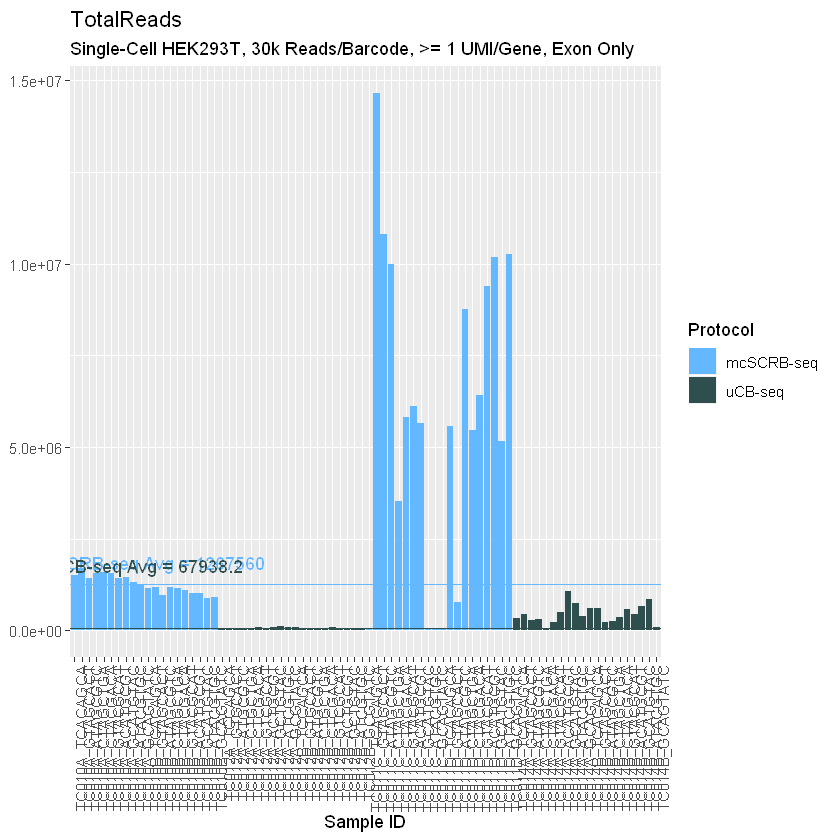

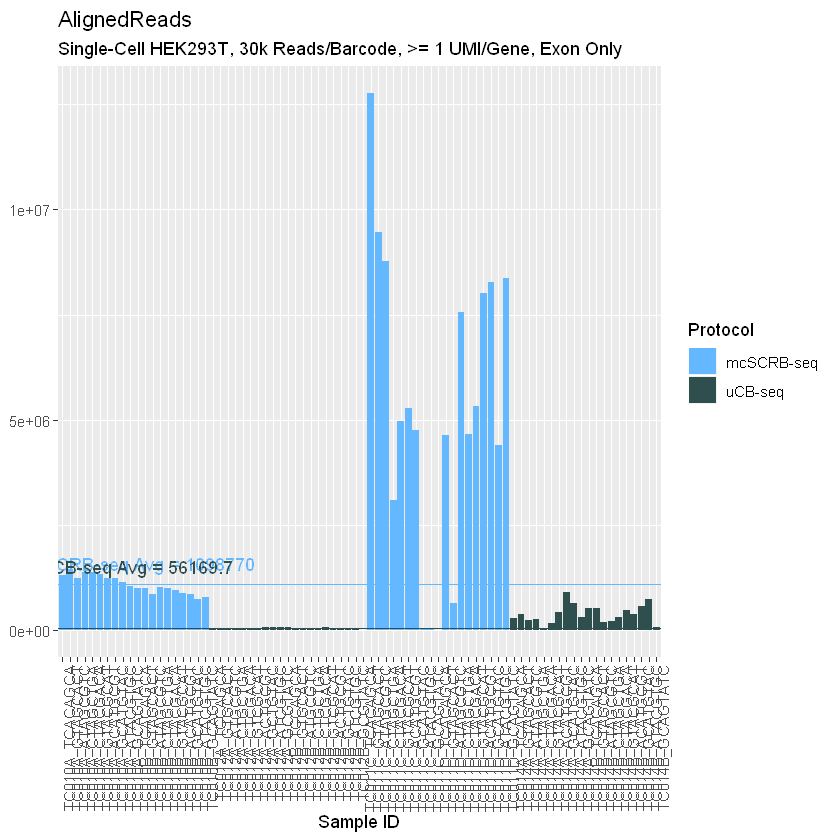

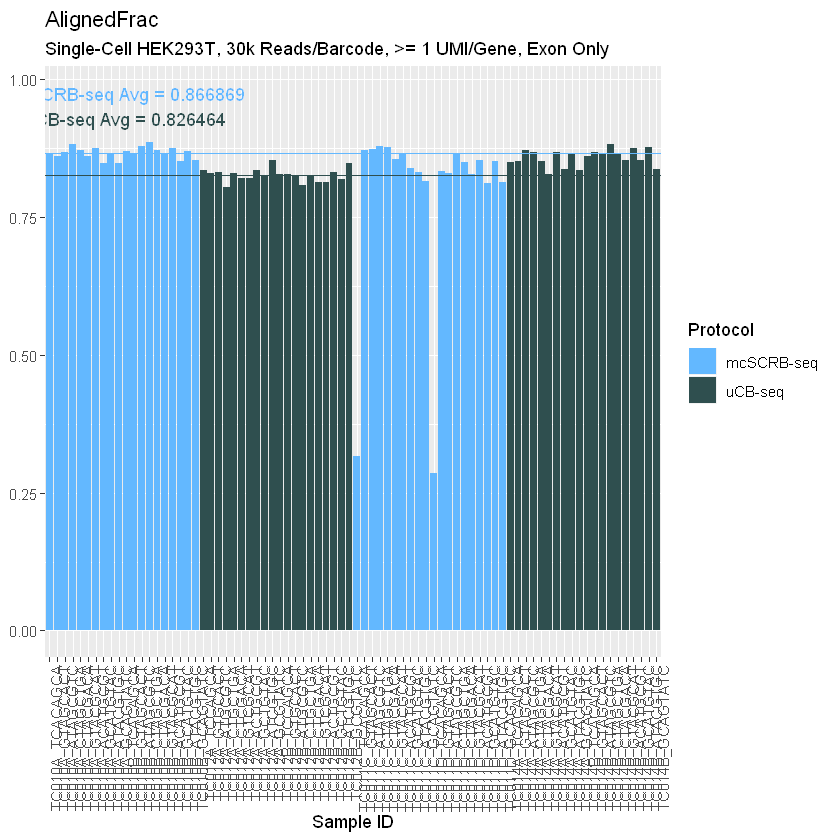

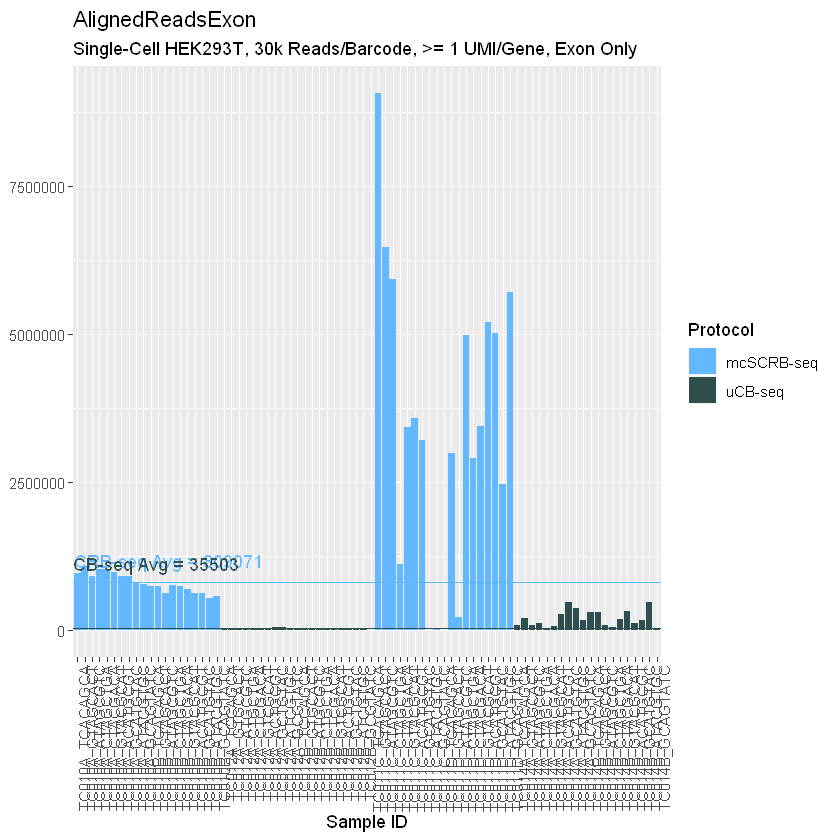

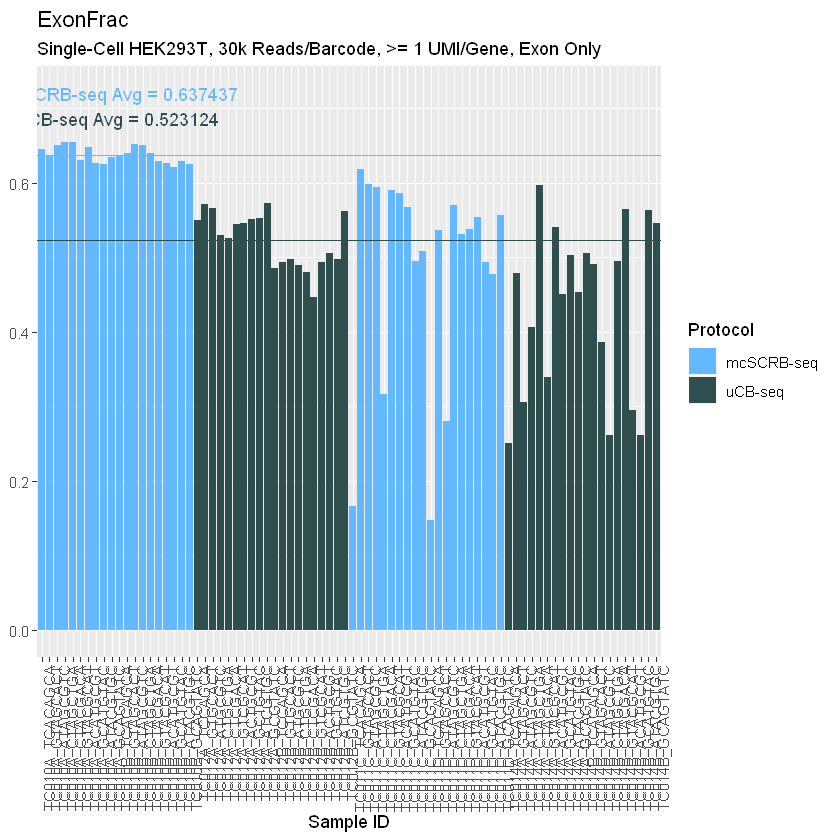

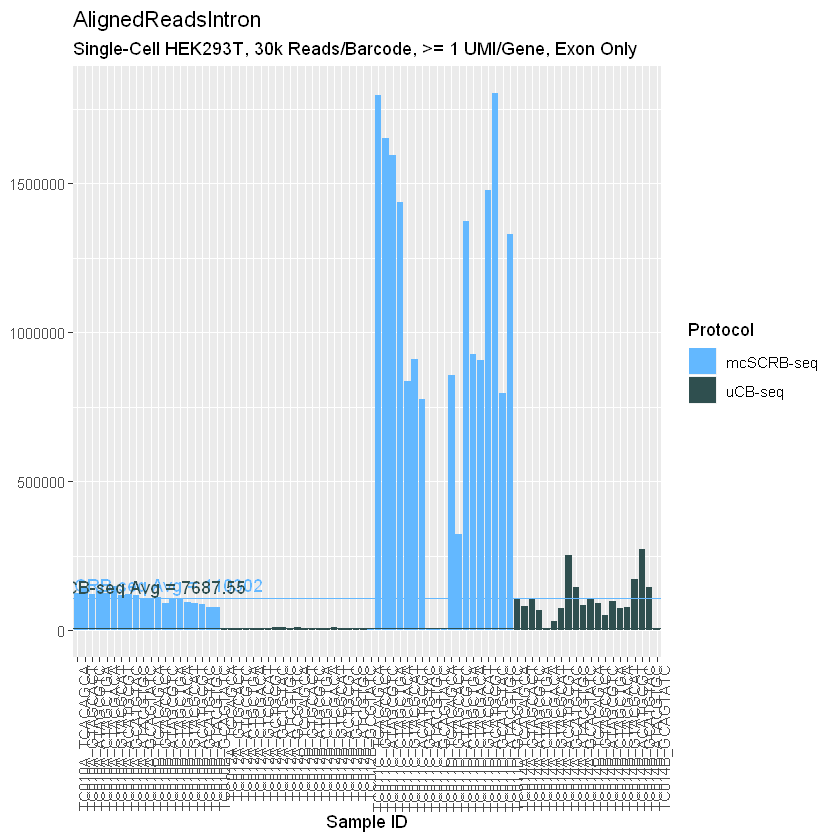

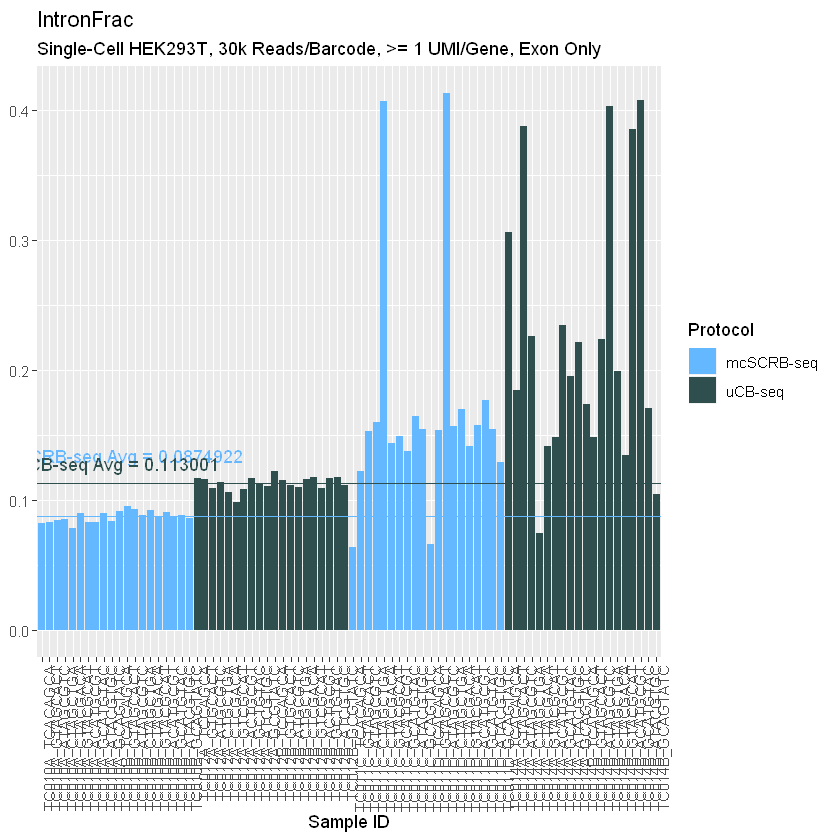

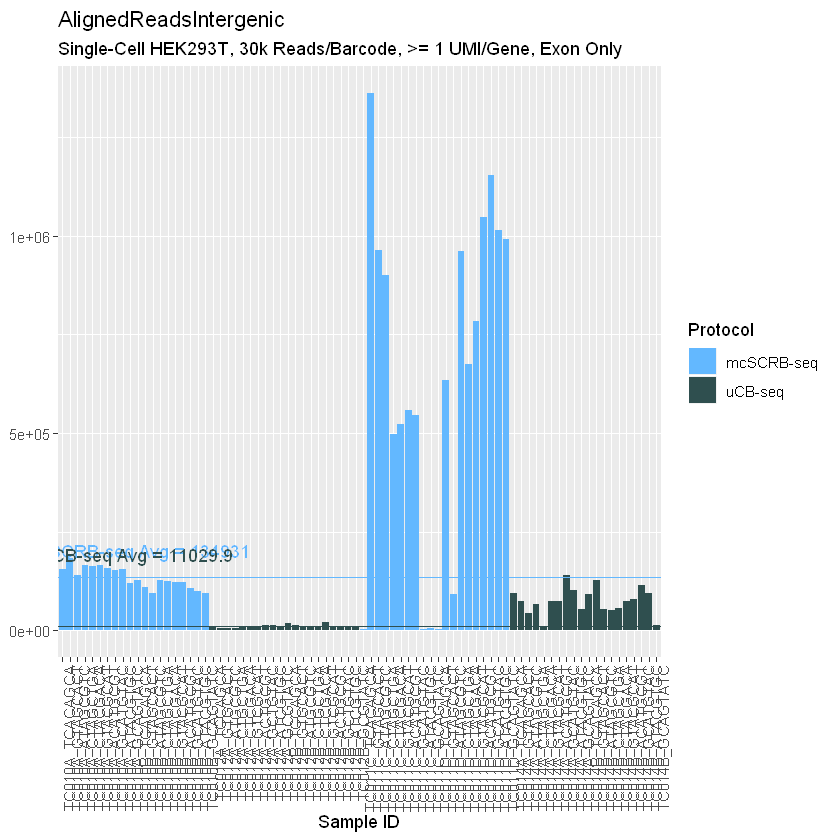

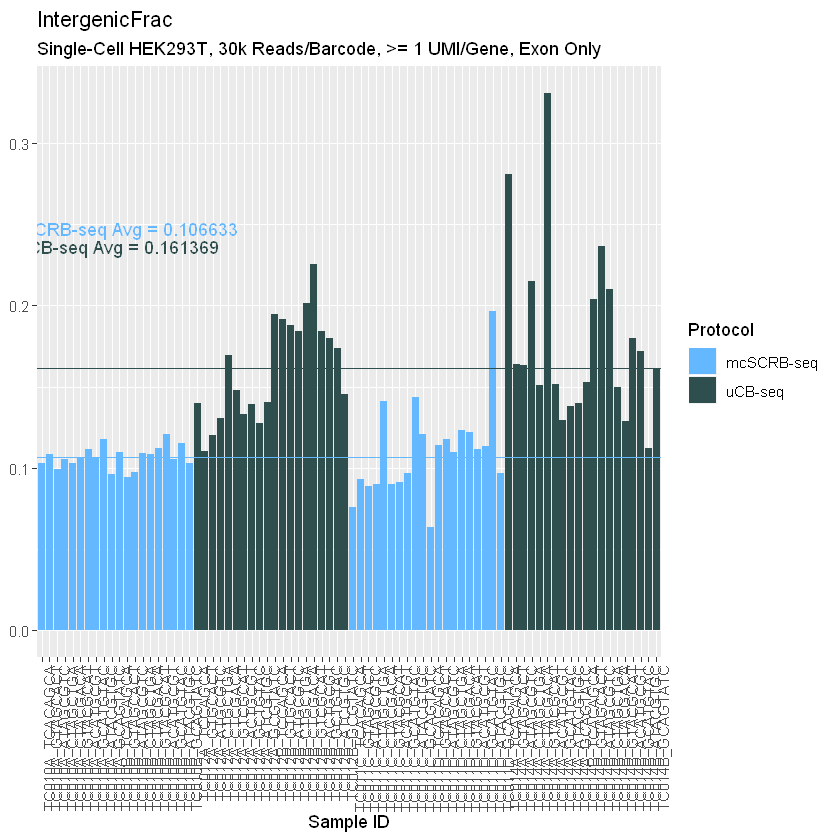

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]

[[8]]

[[9]]

[[10]]

[[11]]


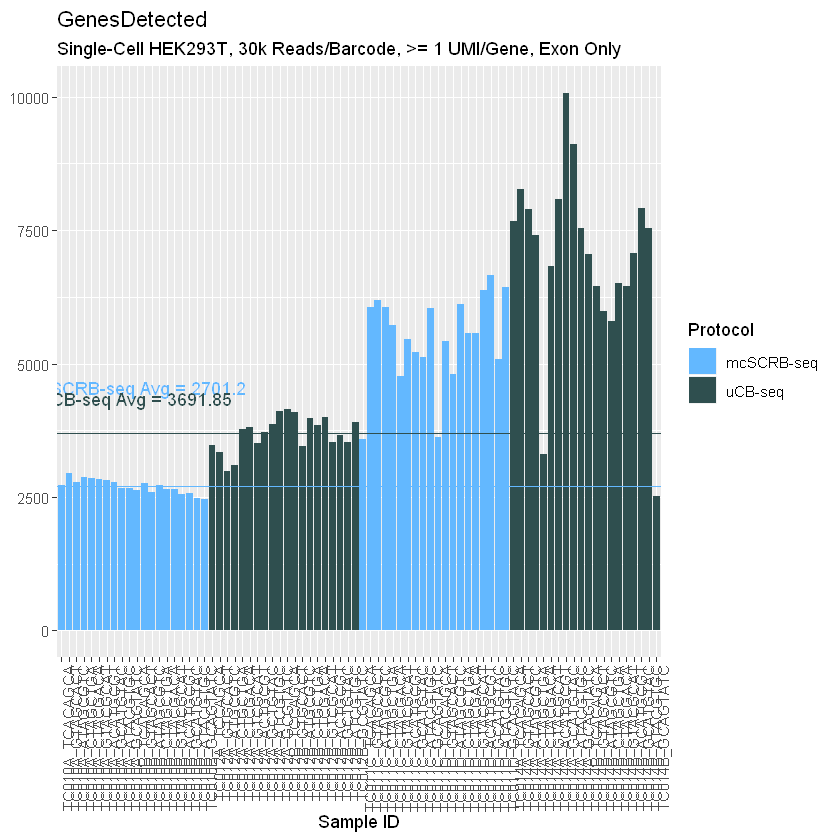

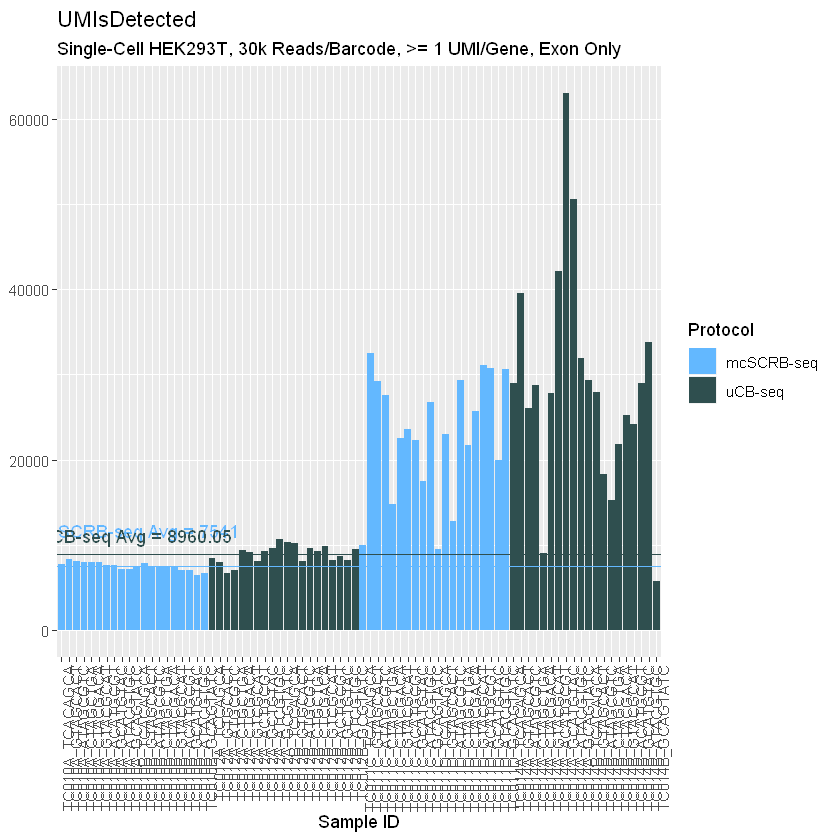

In [26]:
PlotQC <- function(strVar){
    ggplot(colData_Tibble, mapping = aes(x = colnames(uCB_PoC), y = eval(parse(text = paste0('colData_Tibble$', 
            strVar))), fill = as.character(Format))) +
    scale_fill_manual(values = c('steelblue1', 'darkslategray'), name = 'Protocol') +
    geom_bar(stat = "identity") +
    scale_y_continuous(limits = c(0, NA)) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1),axis.title.y=element_blank())+
    ggtitle(strVar, 'Single-Cell HEK293T, 30k Reads/Barcode, >= 1 UMI/Gene, Exon Only') +
    xlab('Sample ID') +
    ylab(strVar) +
    scale_x_discrete(limits=samplesList) + # keep the order of the x axis
    geom_hline(yintercept = eval(parse(text = paste0('mean(colData_Tibble$', strVar, "[1:20])"))), color="steelblue1") +
    geom_hline(yintercept = eval(parse(text = paste0('mean(colData_Tibble$', strVar, "[21:40])"))), color="darkslategray") +
    annotate("text", x = samplesList[11], y = eval(parse(text = paste0('max(colData_Tibble$', strVar, "[1:40]) * 1.10"))), 
            label = paste0("mcSCRB-seq Avg = ", eval(parse(text = paste0('signif(mean(colData_Tibble$', strVar, "[1:20]), digits = 6)")))),
            color = 'steelblue1') + 
    annotate("text", x = samplesList[11], y = eval(parse(text = paste0('max(colData_Tibble$', strVar, "[1:40]) * 1.05"))), 
            label = paste0("uCB-seq Avg = ", eval(parse(text = paste0('signif(mean(colData_Tibble$', strVar, "[21:40]), digits = 6)")))),
            color = 'darkslategray') 
}

qc_to_plot <- c(names(colData_Tibble[-c(1, 2, 3, 4)]))
lapply(qc_to_plot,PlotQC)

_____

# Total RNA Downsampling Analysis

In [8]:
setwd('C:/Users/tyler/Desktop/Downsampled zUMIs/out/TC010Final/')
TC010A <- readRDS('TC010A.dgecounts.rds')
TC010B <- readRDS('TC010B.dgecounts.rds')
setwd('C:/Users/tyler/Desktop/Downsampled zUMIs/out/TC012Final/')
TC012A <- readRDS('TC012A.dgecounts.rds')
TC012B <- readRDS('TC012B.dgecounts.rds')

In [10]:
samples <- c('TC010A', 'TC010B', 'TC012A', 'TC012B')
barcodes <- c('TCACAGCA', 'GTAGCACT', 'ATAGCGTC', 'CTAGCTGA','CTACGACA', 'GTACGCAT', 'ACATGCGT', 'GCATGTAC', 'ATACGTGC', 'GCAGTATC')
barcodes12 <- c('TCCAGCA', 'GTGCACT', 'ATGCGTC', 'CTGCTGA','CTCGACA', 'GTCGCAT', 'ACTGCGT', 'GCTGTAC', 'ATCGTGC', 'GCGTATC')
lookAt <- 'exon'

# Initialize Gene and UMI matrices for all samples at 11 different downsampling values
TC010AGeneMat <- matrix(, nrow = 11, ncol = 10)
TC010AUMIMat <- matrix(, nrow = 11, ncol = 10)
TC010BGeneMat <- matrix(, nrow = 11, ncol = 10)
TC010BUMIMat <- matrix(, nrow = 11, ncol = 10)
TC012AGeneMat <- matrix(, nrow = 11, ncol = 10)
TC012AUMIMat <- matrix(, nrow = 11, ncol = 10)
TC012BGeneMat <- matrix(, nrow = 11, ncol = 10)
TC012BUMIMat <- matrix(, nrow = 11, ncol = 10)

# Define downsampling range to look at as 1M-1k from TC012A
allDepths <- names(TC012A$umicount$exon$downsampling)

for (sample in samples) {
    if (grepl('TC010', sample)) {
        # Name columns and rows of all matrices for easy indexing
        eval(parse(text = paste0('colnames(', sample, 'GeneMat) <- barcodes')))
        eval(parse(text = paste0('rownames(', sample, 'GeneMat) <- allDepths')))
        eval(parse(text = paste0('colnames(', sample, 'UMIMat) <- barcodes')))
        eval(parse(text = paste0('rownames(', sample, 'UMIMat) <- allDepths')))

        eval(parse(text = paste0(sample, 'Depths <- names(', sample, '$umicount$', lookAt, '$downsampling)')))
        for (depth in allDepths) {
            # Check if this specific sample has barcodes with enough reads for specified seq depth
            if (depth %in% eval(parse(text = paste0(sample, 'Depths')))) {
                eval(parse(text = paste0('allowedBarcodes <- colnames(', sample, '$umicount$', lookAt, '$downsampling$', depth, ')')))
                for (barcode in allowedBarcodes) {
                    eval(parse(text = paste0(sample, 'GeneMat["', depth, '","', barcode, '"] <- sum(', sample, '$umicount$', lookAt, '$downsampling$', depth, '[,"', barcode, '"] > 0)')))
                    eval(parse(text = paste0(sample, 'UMIMat["', depth, '","', barcode, '"] <- sum(', sample, '$umicount$', lookAt, '$downsampling$', depth, '[,"', barcode, '"])')))
                }
            }
        }
    } else {
        eval(parse(text = paste0('colnames(', sample, 'GeneMat) <- barcodes12')))
        eval(parse(text = paste0('rownames(', sample, 'GeneMat) <- allDepths')))
        eval(parse(text = paste0('colnames(', sample, 'UMIMat) <- barcodes12')))
        eval(parse(text = paste0('rownames(', sample, 'UMIMat) <- allDepths')))

        eval(parse(text = paste0(sample, 'Depths <- names(', sample, '$umicount$', lookAt, '$downsampling)')))
        for (depth in allDepths) {
            # Check if this specific sample has barcodes with enough reads for specified seq depth
            if (depth %in% eval(parse(text = paste0(sample, 'Depths')))) {
                eval(parse(text = paste0('allowedBarcodes12 <- colnames(', sample, '$umicount$', lookAt, '$downsampling$', depth, ')')))
                for (barcode in allowedBarcodes12) {
                    eval(parse(text = paste0(sample, 'GeneMat["', depth, '","', barcode, '"] <- sum(', sample, '$umicount$', lookAt, '$downsampling$', depth, '[,"', barcode, '"] > 0)')))
                    eval(parse(text = paste0(sample, 'UMIMat["', depth, '","', barcode, '"] <- sum(', sample, '$umicount$', lookAt, '$downsampling$', depth, '[,"', barcode, '"])')))
                }
            }
        }
    }

}

downsampleMatTR <- cbind(TC010AGeneMat, TC010BGeneMat, TC012AGeneMat, TC012BGeneMat)
colnames(downsampleMatTR) = samplesList[1:40]
downsampleMatTR
setwd('C:/Users/tyler/OneDrive/Streets Lab/Jupyter/')
write.table(downsampleMatTR, file = 'HEKTotalRNADownsampleMatrix.csv', append = FALSE, sep = ",", row.names = TRUE)

,TC010A_TCACAGCA,TC010A_GTAGCACT,TC010A_ATAGCGTC,TC010A_CTAGCTGA,TC010A_CTACGACA,TC010A_GTACGCAT,TC010A_ACATGCGT,TC010A_GCATGTAC,TC010A_ATACGTGC,TC010A_GCAGTATC,...,TC012B_TCCAGCA,TC012B_GTGCACT,TC012B_ATGCGTC,TC012B_CTGCTGA,TC012B_CTCGACA,TC012B_GTCGCAT,TC012B_ACTGCGT,TC012B_GCTGTAC,TC012B_ATCGTGC,TC012B_GCGTATC
downsampled_100000,3019,3295,3105,3170,3119,3118,3132,3117,2923,2989,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
downsampled_75000,2798,3111,2935,2958,2919,2946,2905,2923,2704,2804,...,4128,NA,NA,NA,NA,4110,NA,NA,NA,NA
downsampled_50000,2585,2829,2680,2673,2702,2659,2612,2632,2433,2547,...,3810,3817,3157,3695,NA,3798,3222,3310,3168,3599
downsampled_40000,2421,2691,2563,2557,2539,2559,2484,2463,2339,2372,...,3596,3614,3020,3523,3354,3583,3072,3193,3010,3415
downsampled_30000,2281,2464,2376,2397,2389,2404,2350,2318,2181,2241,...,3362,3359,2822,3258,3105,3284,2865,2923,2850,3212
downsampled_20000,2086,2198,2115,2149,2130,2162,2129,2035,1978,1964,...,2903,2960,2579,2865,2768,2882,2572,2644,2557,2873
downsampled_10000,1652,1738,1718,1735,1728,1733,1682,1634,1587,1607,...,2137,2155,1929,2113,2087,2064,2005,1985,1984,2167
downsampled_7500,1467,1523,1502,1511,1445,1513,1518,1469,1408,1395,...,1845,1834,1668,1827,1747,1744,1760,1749,1698,1887
downsampled_5000,1217,1270,1241,1293,1273,1273,1197,1178,1182,1183,...,1435,1447,1314,1417,1361,1341,1371,1354,1377,1473
downsampled_2500,798,846,825,885,839,838,851,826,820,784,...,857,846,845,889,852,816,845,870,848,949


In [12]:
masterGeneMat <- matrix(, nrow = 11, ncol = 3)
masterUMIMat <- matrix(, nrow = 11, ncol = 3)

# Set column/row names for indexing
colnames(masterGeneMat) <- c('Reads', 'mcSCRB-seq', 'uCB-seq')
rownames(masterGeneMat) <- allDepths
colnames(masterUMIMat) <- c('Reads', 'mcSCRB-seq', 'uCB-seq')
rownames(masterUMIMat) <- allDepths

for (depth in allDepths) {
    # Get substring from end of downsampled_DEPTH as numeric for read count
    masterGeneMat[depth,'Reads'] <- as.numeric(unlist(strsplit(depth,'_'))[2])
    masterUMIMat[depth,'Reads'] <- as.numeric(unlist(strsplit(depth,'_'))[2])
    
    # Get average Gene Count for mcSCRB-seq and UCB-seq by summing the counts from each experiment and dividing by 
    # the number of barcodes included in each experiment at that read depth.
    masterGeneMat[depth,'mcSCRB-seq'] <- ((sum(TC010AGeneMat[depth,], na.rm = TRUE) + sum(TC010BGeneMat[depth,], na.rm = TRUE))
                                                / (sum(!is.na(TC010AGeneMat[depth,])) + sum(!is.na(TC010BGeneMat[depth,]))))
    masterUMIMat[depth,'mcSCRB-seq'] <- ((sum(TC010AUMIMat[depth,], na.rm = TRUE) + sum(TC010BUMIMat[depth,], na.rm = TRUE))
                                                / (sum(!is.na(TC010AUMIMat[depth,])) + sum(!is.na(TC010BUMIMat[depth,]))))
    masterGeneMat[depth,'uCB-seq'] <- ((sum(TC012AGeneMat[depth,], na.rm = TRUE) + sum(TC012BGeneMat[depth,], na.rm = TRUE))
                                                / (sum(!is.na(TC012AGeneMat[depth,])) + sum(!is.na(TC012BGeneMat[depth,]))))
    masterUMIMat[depth,'uCB-seq'] <- ((sum(TC012AUMIMat[depth,], na.rm = TRUE) + sum(TC012BUMIMat[depth,], na.rm = TRUE))
                                                / (sum(!is.na(TC012AUMIMat[depth,])) + sum(!is.na(TC012BUMIMat[depth,]))))
}
masterGeneDf <- as.data.frame(masterGeneMat)
masterGeneDf <- reshape2::melt(masterGeneDf, id=c("Reads"))
colnames(masterGeneDf)[colnames(masterGeneDf) == 'variable'] <- 'Protocol'
colnames(masterGeneDf)[colnames(masterGeneDf) == 'value'] <- 'Genes'

masterUMIDf <- as.data.frame(masterUMIMat)
masterUMIDf <- reshape2::melt(masterUMIDf, id=c("Reads"))
colnames(masterUMIDf)[colnames(masterUMIDf) == 'variable'] <- 'Protocol'
colnames(masterUMIDf)[colnames(masterUMIDf) == 'value'] <- 'UMIs'

`geom_smooth()` using method = 'loess' and formula 'y ~ log(x)'


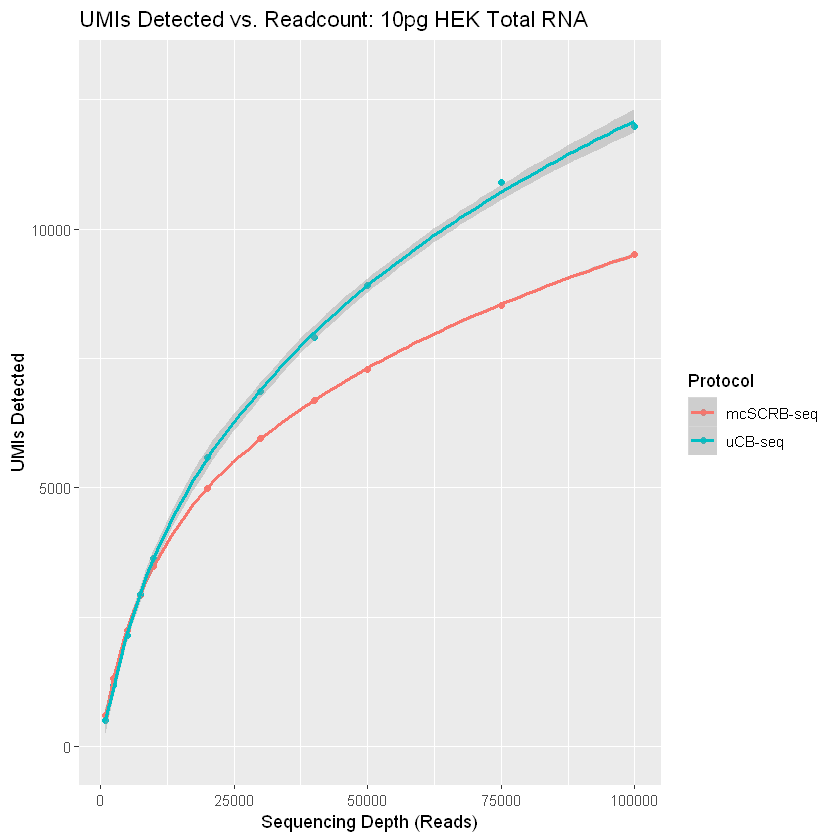

In [13]:
# Plot UMIs Detected

ggplot(masterUMIDf, aes(x = Reads, y = UMIs, color = Protocol)) + 
geom_point() +
geom_smooth(formula = y ~ log(x)) +
xlab('Sequencing Depth (Reads)') +
ylab('UMIs Detected') +
ggtitle('UMIs Detected vs. Readcount: 10pg HEK Total RNA') + 
scale_color_discrete(name = 'Protocol', labels = c('mcSCRB-seq', 'uCB-seq')) + 
ylim(-100, 13000)

`geom_smooth()` using method = 'loess' and formula 'y ~ log(x)'


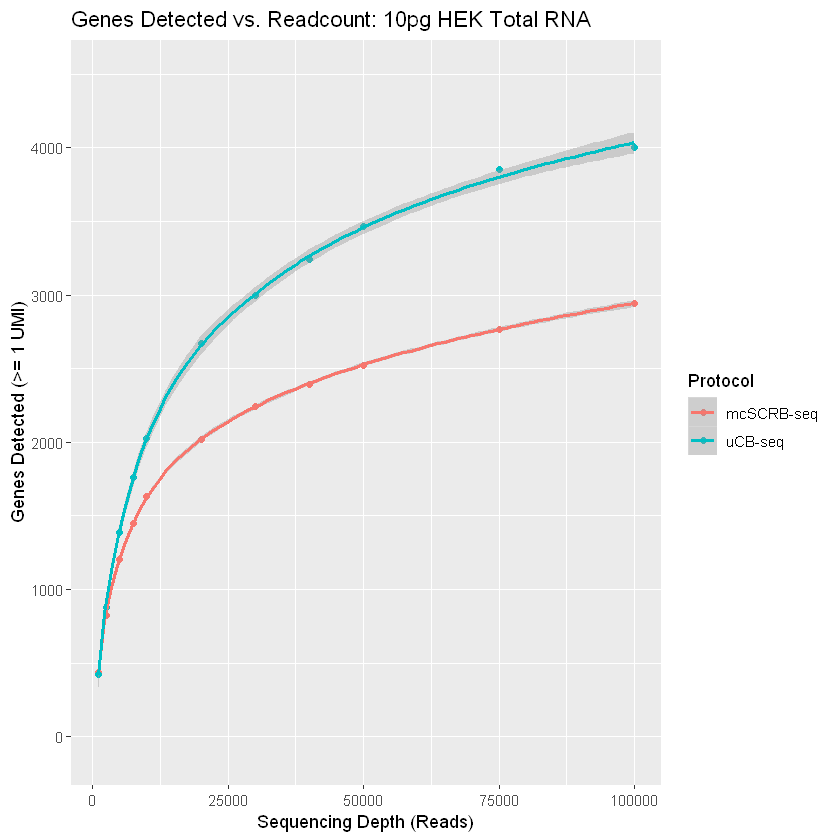

In [14]:
# Plot Genes Detected

ggplot(masterGeneDf, aes(x = Reads, y = Genes, color = Protocol)) + 
geom_point() +
geom_smooth(formula = y ~ log(x)) +
xlab('Sequencing Depth (Reads)') +
ylab('Genes Detected (>= 1 UMI)') +
ggtitle('Genes Detected vs. Readcount: 10pg HEK Total RNA') +
scale_color_discrete(name = 'Protocol', labels = c('mcSCRB-seq', 'uCB-seq')) +
ylim(-100, 4500)

## Boxplot of Genes and UMIs by Protocol

In [15]:
temp1 <- cbind(TC012AUMIMat, TC012BUMIMat)['downsampled_50000',]
names(temp1) <- NULL
temp2 <- cbind(TC012AGeneMat, TC012BGeneMat)['downsampled_50000',]
names(temp2) <- NULL
temp1 <- temp1[!is.na(temp1)]
temp2 <- temp2[!is.na(temp2)]

ucbBoxData <- as.data.frame(cbind(temp1, temp2))
ucbBoxData$Protocol <- c(rep('uCB-seq'))
colnames(ucbBoxData) <- c('UMIs', 'Genes', 'Protocol')

temp1 <- cbind(TC010AUMIMat, TC010BUMIMat)['downsampled_50000',]
names(temp1) <- NULL
temp2 <- cbind(TC010AGeneMat, TC010BGeneMat)['downsampled_50000',]
names(temp2) <- NULL
temp1 <- temp1[!is.na(temp1)]
temp2 <- temp2[!is.na(temp2)]

mcBoxData <- as.data.frame(cbind(temp1, temp2))
mcBoxData$Protocol <- c(rep('mcSCRB-seq'))
colnames(mcBoxData) <- c('UMIs', 'Genes', 'Protocol')

boxData <- rbind(ucbBoxData, mcBoxData)

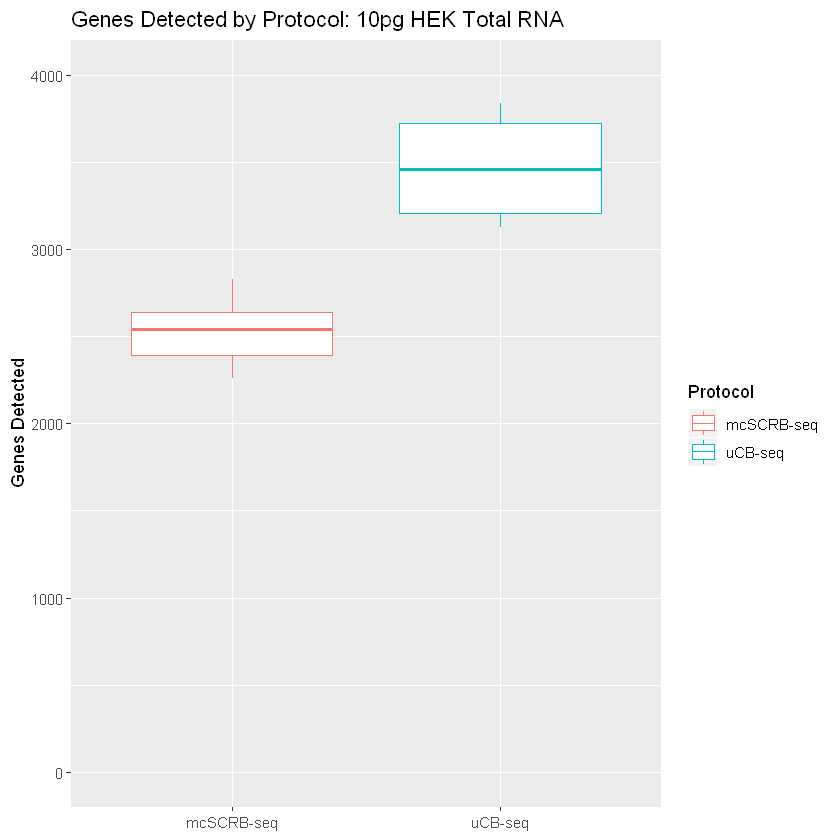

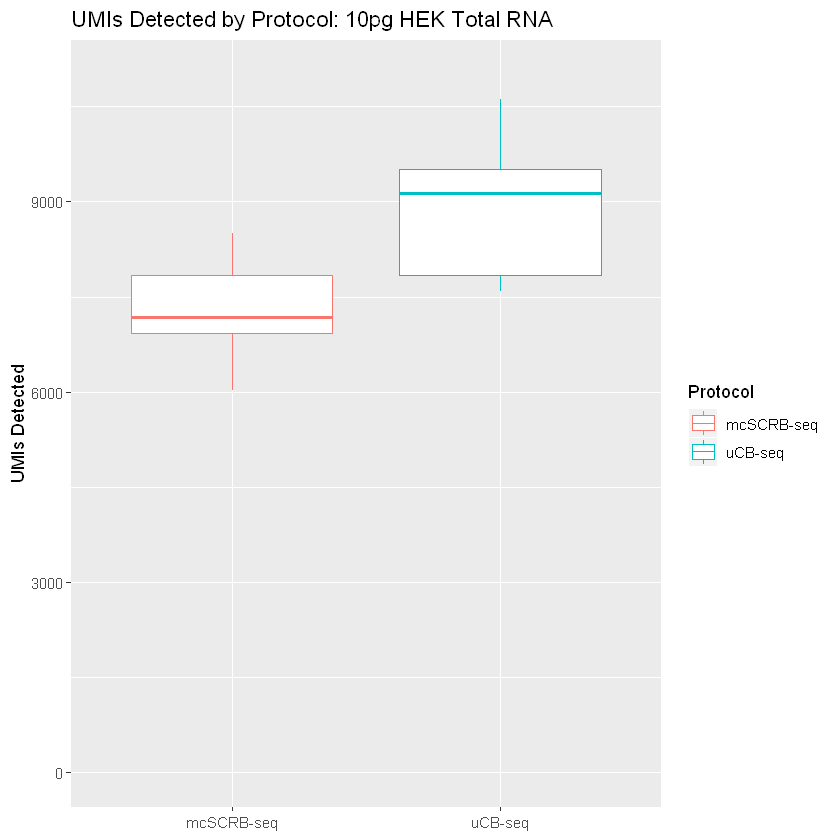

In [16]:
# Genes Detected
ggplot(boxData, aes(x=Protocol, y=Genes, color=Protocol)) + 
geom_boxplot() + 
xlab(NULL) +
ylab('Genes Detected') +
ggtitle('Genes Detected by Protocol: 10pg HEK Total RNA') +
scale_color_discrete(name = 'Protocol', labels = c('mcSCRB-seq', 'uCB-seq')) +
ylim(0, 4000)

# UMIs Detected
ggplot(boxData, aes(x=Protocol, y=UMIs, color=Protocol)) + 
geom_boxplot() + 
xlab(NULL) +
ylab('UMIs Detected') +
ggtitle('UMIs Detected by Protocol: 10pg HEK Total RNA') +
scale_color_discrete(name = 'Protocol', labels = c('mcSCRB-seq', 'uCB-seq')) +
ylim(0, 11000)

# Single Cell Downsampling Analysis

In [17]:
setwd('C:/Users/tyler/Desktop/Downsampled zUMIs/out/TC014Final/')
TC014A <- readRDS('TC014A.dgecounts.rds')
TC014B <- readRDS('TC014B.dgecounts.rds')
setwd('C:/Users/tyler/Desktop/Downsampled zUMIs/out/TC011Final/')
TC011C <- readRDS('TC011C.dgecounts.rds')
TC011D <- readRDS('TC011D.dgecounts.rds')

In [18]:
samples <- c('TC011C', 'TC011D', 'TC014A', 'TC014B')
barcodes <- c('TCACAGCA', 'GTAGCACT', 'ATAGCGTC', 'CTAGCTGA','CTACGACA', 'GTACGCAT', 'ACATGCGT', 'GCATGTAC', 'ATACGTGC', 'GCAGTATC')
TC011CNegList <- c('ATACGTGC', 'GCAGTATC', 'TCACAGCA')
TC011DNegList <- c('TCACAGCA')
TC014ANegList <- c('CTACGACA')
TC014BNegList <- c('GCAGTATC')
TC011Cbarcodes <- barcodes
TC011Dbarcodes <- barcodes
TC014Abarcodes <- barcodes
TC014Bbarcodes <- barcodes
lookAt <- 'exon'

# Initialize Gene and UMI matrices for all samples at 18 different downsampling values
TC014AGeneMat <- matrix(, nrow = 18, ncol = length(TC014Abarcodes))
TC014AUMIMat <- matrix(, nrow = 18, ncol = length(TC014Abarcodes))
TC014BGeneMat <- matrix(, nrow = 18, ncol = length(TC014Bbarcodes))
TC014BUMIMat <- matrix(, nrow = 18, ncol = length(TC014Bbarcodes))
TC011CGeneMat <- matrix(, nrow = 18, ncol = length(TC011Cbarcodes))
TC011CUMIMat <- matrix(, nrow = 18, ncol = length(TC011Cbarcodes))
TC011DGeneMat <- matrix(, nrow = 18, ncol = length(TC011Dbarcodes))
TC011DUMIMat <- matrix(, nrow = 18, ncol = length(TC011Dbarcodes))

# Define downsampling range to look at as 1M-1k from TC014A
allDepths <- names(TC014A$umicount$exon$downsampling)

for (sample in samples) {
    # Name columns and rows of all matrices for easy indexing
    eval(parse(text = paste0('colnames(', sample, 'GeneMat) <- ', sample, 'barcodes')))
    eval(parse(text = paste0('rownames(', sample, 'GeneMat) <- allDepths')))
    eval(parse(text = paste0('colnames(', sample, 'UMIMat) <- ', sample, 'barcodes')))
    eval(parse(text = paste0('rownames(', sample, 'UMIMat) <- allDepths')))

    eval(parse(text = paste0(sample, 'Depths <- names(', sample, '$umicount$', lookAt, '$downsampling)')))
    for (depth in allDepths) {
        # Check if this specific sample has barcodes with enough reads for specified seq depth
        if (depth %in% eval(parse(text = paste0(sample, 'Depths')))) {
            eval(parse(text = paste0('allowedBarcodes <- colnames(', sample, '$umicount$', lookAt, '$downsampling$', depth, ')')))
            for (barcode in allowedBarcodes) {
                # If barcode is a non-cell barcode, set value to NA
                if (barcode %in% eval(parse(text = paste0(sample, 'NegList')))) {
                    eval(parse(text = paste0(sample, 'GeneMat["', depth, '","', barcode, '"] <- NA')))
                    eval(parse(text = paste0(sample, 'UMIMat["', depth, '","', barcode, '"] <- NA')))
                } else {
                    eval(parse(text = paste0(sample, 'GeneMat["', depth, '","', barcode, '"] <- sum(', sample, '$umicount$', lookAt, '$downsampling$', depth, '[,"', barcode, '"] >= 1)')))
                    eval(parse(text = paste0(sample, 'UMIMat["', depth, '","', barcode, '"] <- sum(', sample, '$umicount$', lookAt, '$downsampling$', depth, '[,"', barcode, '"])')))
                }
            }
        }
    }
    
}

downsampleMatSC <- cbind(TC011CGeneMat, TC011DGeneMat, TC014AGeneMat, TC014BGeneMat)
colnames(downsampleMatSC) = samplesList[41:80]
downsampleMatSC
setwd('C:/Users/tyler/OneDrive/Streets Lab/Jupyter/')
write.table(downsampleMatSC, file = 'HEKSingleCellDownsampleMatrix.csv', append = FALSE, sep = ",", row.names = TRUE)

downsampleUMIMatSC <- cbind(TC011CUMIMat, TC011DUMIMat, TC014AUMIMat, TC014BUMIMat)
colnames(downsampleUMIMatSC) = samplesList[41:80]
downsampleUMIMatSC
setwd('C:/Users/tyler/OneDrive/Streets Lab/Jupyter/')
write.table(downsampleUMIMatSC, file = 'HEKSingleCellUMIDownsampleMatrix.csv', append = FALSE, sep = ",", row.names = TRUE)

,TC011C_TCACAGCA,TC011C_GTAGCACT,TC011C_ATAGCGTC,TC011C_CTAGCTGA,TC011C_CTACGACA,TC011C_GTACGCAT,TC011C_ACATGCGT,TC011C_GCATGTAC,TC011C_ATACGTGC,TC011C_GCAGTATC,...,TC014B_TCACAGCA,TC014B_GTAGCACT,TC014B_ATAGCGTC,TC014B_CTAGCTGA,TC014B_CTACGACA,TC014B_GTACGCAT,TC014B_ACATGCGT,TC014B_GCATGTAC,TC014B_ATACGTGC,TC014B_GCAGTATC
downsampled_1000000,NA,6110,6184,6256,5303,5434,6035,5916,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
downsampled_500000,NA,5313,5443,5356,4146,4400,5111,4873,NA,NA,...,6150,5655,NA,NA,NA,5645,NA,6125,6416,NA
downsampled_250000,NA,4706,4793,4606,3275,3633,4269,3958,NA,NA,...,5447,4912,NA,NA,4877,5055,4521,5123,5861,NA
downsampled_200000,NA,4508,4568,4442,3003,3391,4051,3779,NA,NA,...,5175,4703,4206,3260,4633,4919,4290,4852,5686,NA
downsampled_175000,NA,4424,4412,4271,2874,3280,3899,3646,NA,NA,...,5081,4610,4092,3078,4531,4852,4130,4644,5570,NA
downsampled_150000,NA,4273,4326,4153,2667,3195,3770,3485,NA,NA,...,4937,4457,3852,2887,4369,4709,3947,4424,5501,NA
downsampled_125000,NA,4130,4180,3933,2470,2971,3550,3296,NA,NA,...,4784,4333,3659,2724,4202,4602,3699,4255,5346,NA
downsampled_100000,NA,3931,4016,3829,2358,2868,3422,3132,NA,NA,...,4586,4160,3331,2521,4008,4489,3529,4002,5212,NA
downsampled_75000,NA,3751,3823,3561,2134,2659,3212,2944,NA,NA,...,4314,3927,3121,2238,3768,4298,3141,3629,4951,NA
downsampled_50000,NA,3359,3405,3217,1843,2418,2861,2563,NA,NA,...,3921,3553,2680,1941,3430,3970,2769,3150,4522,NA


,TC011C_TCACAGCA,TC011C_GTAGCACT,TC011C_ATAGCGTC,TC011C_CTAGCTGA,TC011C_CTACGACA,TC011C_GTACGCAT,TC011C_ACATGCGT,TC011C_GCATGTAC,TC011C_ATACGTGC,TC011C_GCAGTATC,...,TC014B_TCACAGCA,TC014B_GTAGCACT,TC014B_ATAGCGTC,TC014B_CTAGCTGA,TC014B_CTACGACA,TC014B_GTACGCAT,TC014B_ACATGCGT,TC014B_GCATGTAC,TC014B_ATACGTGC,TC014B_GCAGTATC
downsampled_1000000,NA,39825,36199,35108,19833,30975,33362,32170,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
downsampled_500000,NA,30185,26798,24959,12075,20820,22209,21234,NA,NA,...,27361,26694,NA,NA,NA,23924,NA,21635,31248,NA
downsampled_250000,NA,23829,20600,18702,7780,14847,15726,14869,NA,NA,...,20810,20157,NA,NA,14622,18644,13788,15243,24752,NA
downsampled_200000,NA,22038,19201,17259,6787,13603,14420,13549,NA,NA,...,18989,18491,11343,7546,13205,17266,12470,13764,22973,NA
downsampled_175000,NA,21235,18252,16379,6361,12861,13509,12609,NA,NA,...,18109,17610,10676,6970,12679,16579,11547,12886,21909,NA
downsampled_150000,NA,20090,17170,15418,5789,12204,12743,11869,NA,NA,...,17043,16724,9780,6331,11844,15701,10736,11864,20928,NA
downsampled_125000,NA,18877,16299,14521,5238,11203,11751,10976,NA,NA,...,15949,15510,8946,5672,11064,14768,9851,10847,19736,NA
downsampled_100000,NA,17369,15073,13348,4779,10417,10935,10049,NA,NA,...,14522,14182,7922,5095,10038,13763,8903,9742,18107,NA
downsampled_75000,NA,15566,13520,12103,4137,9288,9613,9125,NA,NA,...,12994,12653,6975,4293,8894,12525,7699,8418,16208,NA
downsampled_50000,NA,13130,11341,10251,3399,8031,8158,7649,NA,NA,...,10641,10525,5696,3486,7570,10693,6155,6742,13484,NA


In [20]:
masterGeneMat <- matrix(, nrow = 18, ncol = 3)
masterUMIMat <- matrix(, nrow = 18, ncol = 3)

# Set column/row names for indexing
colnames(masterGeneMat) <- c('Reads', 'mcSCRB-seq', 'uCB-seq')
rownames(masterGeneMat) <- allDepths
colnames(masterUMIMat) <- c('Reads', 'mcSCRB-seq', 'uCB-seq')
rownames(masterUMIMat) <- allDepths

for (depth in allDepths) {
    # Get substring from end of downsampled_DEPTH as numeric for read count
    masterGeneMat[depth,'Reads'] <- as.numeric(unlist(strsplit(depth,'_'))[2])
    masterUMIMat[depth,'Reads'] <- as.numeric(unlist(strsplit(depth,'_'))[2])
    
    # Get average Gene Count for mcSCRB-seq and uCB-seq by summing the counts from each experiment and dividing by 
    # the number of barcodes included in each experiment at that read depth.
    masterGeneMat[depth,'mcSCRB-seq'] <- ((sum(TC011CGeneMat[depth,], na.rm = TRUE) + sum(TC011DGeneMat[depth,], na.rm = TRUE))
                                                / (sum(!is.na(TC011CGeneMat[depth,])) + sum(!is.na(TC011DGeneMat[depth,]))))
    masterUMIMat[depth,'mcSCRB-seq'] <- ((sum(TC011CUMIMat[depth,], na.rm = TRUE) + sum(TC011DUMIMat[depth,], na.rm = TRUE))
                                                / (sum(!is.na(TC011CUMIMat[depth,])) + sum(!is.na(TC011DUMIMat[depth,]))))
    masterGeneMat[depth,'uCB-seq'] <- ((sum(TC014AGeneMat[depth,], na.rm = TRUE) + sum(TC014BGeneMat[depth,], na.rm = TRUE))
                                                / (sum(!is.na(TC014AGeneMat[depth,])) + sum(!is.na(TC014BGeneMat[depth,]))))
    masterUMIMat[depth,'uCB-seq'] <- ((sum(TC014AUMIMat[depth,], na.rm = TRUE) + sum(TC014BUMIMat[depth,], na.rm = TRUE))
                                                / (sum(!is.na(TC014AUMIMat[depth,])) + sum(!is.na(TC014BUMIMat[depth,]))))
}
masterGeneDf <- as.data.frame(masterGeneMat)
masterGeneDf <- reshape2::melt(masterGeneDf, id=c("Reads"))
colnames(masterGeneDf)[colnames(masterGeneDf) == 'variable'] <- 'Protocol'
colnames(masterGeneDf)[colnames(masterGeneDf) == 'value'] <- 'Genes'

masterUMIDf <- as.data.frame(masterUMIMat)
masterUMIDf <- reshape2::melt(masterUMIDf, id=c("Reads"))
colnames(masterUMIDf)[colnames(masterUMIDf) == 'variable'] <- 'Protocol'
colnames(masterUMIDf)[colnames(masterUMIDf) == 'value'] <- 'UMIs'

`geom_smooth()` using method = 'loess' and formula 'y ~ log(x)'
Warning message:
"Removed 6 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 6 rows containing missing values (geom_point)."

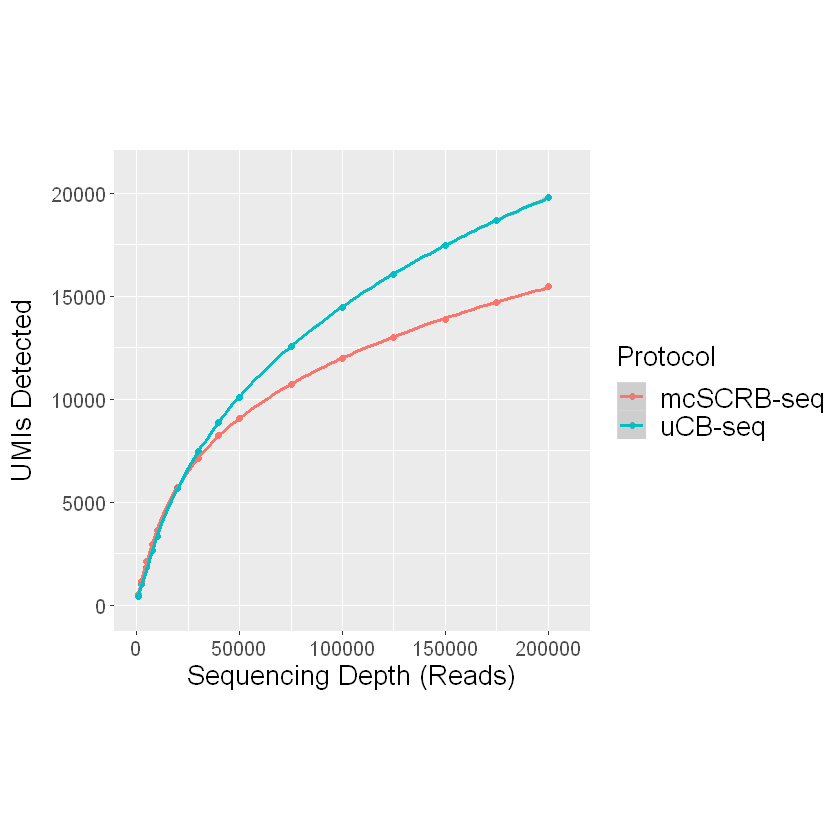

In [21]:
# Plot UMIs Detected

ggplot(masterUMIDf, aes(x = Reads, y = UMIs, color = Protocol)) + 
geom_point() +
geom_smooth(formula = y ~ log(x)) +
xlab('Sequencing Depth (Reads)') +
ylab('UMIs Detected') +
# ggtitle('UMIs Detected vs. Readcount: Single-Cell HEK') + 
scale_color_discrete(name = 'Protocol', labels = c('mcSCRB-seq', 'uCB-seq')) + 
ylim(-200, 21000) + 
xlim(0, 210000) +
coord_fixed(ratio=10) +
theme(plot.title = element_text(size=24), axis.text.x = element_text(size=12), axis.title.x = element_text(size=16), axis.title.y = element_text(size=16, margin = margin(t = 0, r = 10, b = 0, l = 0)),
      axis.text.y = element_text(size=12), legend.text = element_text(size=16), legend.title = element_text(size=16))

`geom_smooth()` using method = 'loess' and formula 'y ~ log(x)'
Warning message:
"Removed 6 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 6 rows containing missing values (geom_point)."

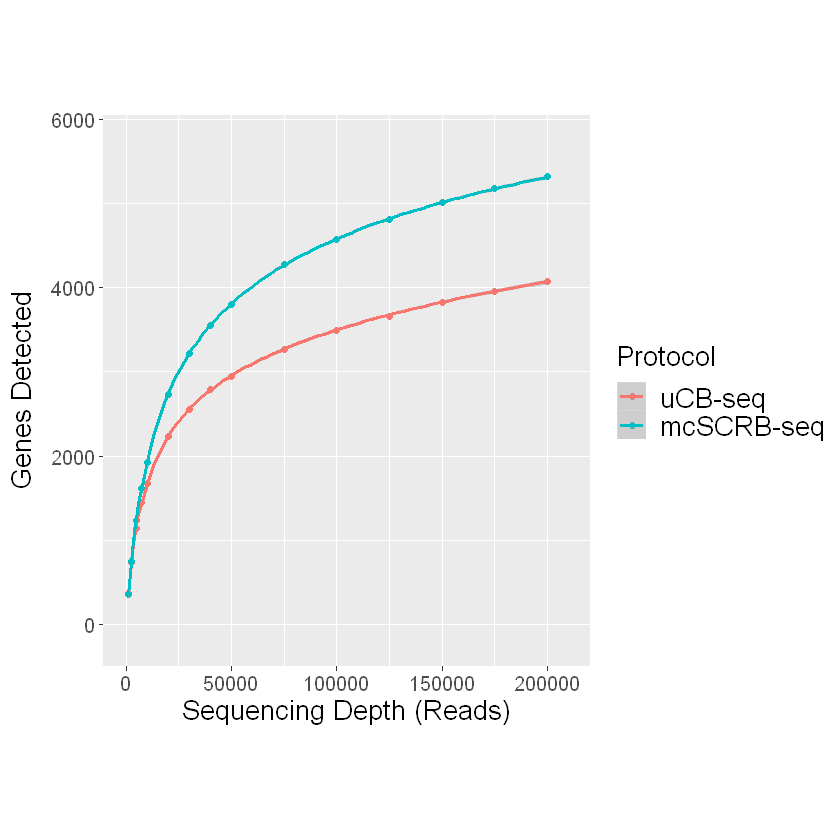

In [126]:
# Plot Genes Detected

ggplot(masterGeneDf, aes(x = Reads, y = Genes, color = Protocol)) + 
geom_point() +
geom_smooth(formula = y ~ log(x)) +
xlab('Sequencing Depth (Reads)') +
ylab('Genes Detected') +
# ggtitle('Library Complexity') +
scale_color_discrete(name = 'Protocol', labels = c('uCB-seq', 'mcSCRB-seq')) +
ylim(-200, 5750) + 
xlim(0, 210000) + 
coord_fixed(ratio=40)+
theme(plot.title = element_text(size=24), axis.text.x = element_text(size=12), axis.title.x = element_text(size=16), axis.title.y = element_text(size=16, margin = margin(t = 0, r = 10, b = 0, l = 0)),
      axis.text.y = element_text(size=12), legend.text = element_text(size=16), legend.title = element_text(size=16))